In [1]:
%matplotlib inline

import os
while 'source' not in os.listdir():
    os.chdir('..')
os.chdir('source')

FORCE = False

import gpu

In [2]:
from util import getHashId


props={
    'path'          : 'data',
    'seed'          : 42,
    'split'         : 0.8,
    'test_split'    : 0.5,
    'control'       : True,
    'huntington'    : False,
    'left'          : True,
    'right'         : True,
    'threshold'     : None,
    'binarize'      : False,
    'not_connected' : False,
    'single'        : None,
    'features'      : [],
    'features_vox'  : [],
    'radiomics'     : [
        #{'sp':'normalized','im':'t1t2','fe':['b25'],'fi':['roi','t1_mask']},
    ],
    'space'         : 'normalized',
    'radiomics_vox' : [
        {'im':'t1t2','fe':['k5_b50','k7_b50','k9_b50','k11_b50','k13_b50','k15_b50','k17_b50','k19_b50','k21_b50']},
    ],
    'rad_vox_norm'  : 'norm',
    'inps'          : [],
    'features_clin' : None,
    'outp'          : 'diffusion_fa',
    'balance_data'  : False,
    'exclude'       : ['t1t2','normalized'],
    'include_warp'  : True,
    'collapse_max'  : False,
    'collapse_bin'  : False,
}

architecture={
    'activation'    : 'sigmoid',
    'layers'        : [1024,512,256,128],
    'loss'          : 'MSE',
    'learning_rate' : 0.001,
    'batch_size'    : 10000,
    'patience'      : 7,
}

HASHID, HASH = getHashId(architecture,props)
print(HASH)

sigmoid_10000_1024_512_256_128_0001_MSE_7_0_0_0_0_1_t1t2_normalized_e_n_e_0_1_e_1_0_diffusion_fa_data_scale_e_k5_b25_k7_b25_k9_b25_k11_b25_k13_b25_k15_b25_k17_b25_k19_b25_k21_b25_t1_1_42_n_native_08_05_n


In [3]:
from DataGenerator import DataGenerator

gen = DataGenerator(**props)
train, val, test = gen.getData()

print('train')
print(train[0].shape)
print(train[1].shape)
print('validation')
print(val[0].shape)
print(val[1].shape)
print('test')
print(test[0].shape)
print(test[1].shape)

train
(631390, 828)
(631390, 1)
validation
(74368, 828)
(74368, 1)
test
(85358, 828)
(85358, 1)


In [4]:
from Model import *
from tensorflow.keras.optimizers import Adam

path = props['path']+'/models'

stop = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=architecture['patience'],
)
save = tf.keras.callbacks.ModelCheckpoint(
    filepath=path+'/{}.weights.h5'.format(HASHID),
    monitor='val_loss',
    mode='min',
    save_best_only=True,
    save_weights_only=True,
)

model = buildModel(train[0].shape[1], train[1].shape[1], activation=architecture['activation'], layers=architecture['layers'])

model.compile(loss=locals()[architecture['loss']], optimizer=Adam(learning_rate=architecture['learning_rate']), jit_compile=True, metrics=[STD,MAE])

model.summary()

Model: "FFN"


_________________________________________________________________


 Layer (type)                Output Shape              Param #   


 input_1 (InputLayer)        [(None, 828)]             0         


 dense (Dense)               (None, 1024)              848896    


 dense_1 (Dense)             (None, 512)               524800    


 dense_2 (Dense)             (None, 256)               131328    


 dense_3 (Dense)             (None, 128)               32896     


 dense_4 (Dense)             (None, 1)                 129       


Total params: 1538049 (5.87 MB)


Trainable params: 1538049 (5.87 MB)


Non-trainable params: 0 (0.00 Byte)


_________________________________________________________________


In [5]:
import os
from util import pickleSave

if FORCE or not os.path.exists(path+'/{}.pkl'.format(HASHID)):
    history = model.fit(DataWrapper(train,architecture['batch_size']),
        validation_data=DataWrapper(val,architecture['batch_size'],False),
        epochs=10000,
        verbose=1,
        callbacks = [save,stop],
    )
    pickleSave(path+'/{}.pkl'.format(HASHID), history.history)

model.load_weights(path+'/{}.weights.h5'.format(HASHID))

Epoch 1/10000



 1/64 [..............................] - ETA: 1:14 - loss: 0.2214 - STD: 1.8482e-04 - MAE: 0.4600


 4/64 [>.............................] - ETA: 1s - loss: 0.0750 - STD: 5.4521e-04 - MAE: 0.2111  


 5/64 [=>............................] - ETA: 1s - loss: 0.0638 - STD: 4.8818e-04 - MAE: 0.1896


 6/64 [=>............................] - ETA: 2s - loss: 0.0571 - STD: 4.3296e-04 - MAE: 0.1780


 7/64 [==>...........................] - ETA: 2s - loss: 0.0527 - STD: 3.8550e-04 - MAE: 0.1712


 8/64 [==>...........................] - ETA: 2s - loss: 0.0497 - STD: 3.4581e-04 - MAE: 0.1669


 9/64 [===>..........................] - ETA: 2s - loss: 0.0474 - STD: 3.1255e-04 - MAE: 0.1639


10/64 [===>..........................] - ETA: 2s - loss: 0.0457 - STD: 2.8467e-04 - MAE: 0.1619


11/64 [====>.........................] - ETA: 2s - loss: 0.0443 - STD: 2.6093e-04 - MAE: 0.1602


12/64 [====>.........................] - ETA: 2s - loss: 0.0432 - STD: 2.4061e-04 - MAE: 0.1588


13/64 [=====>........................] - ETA: 2s - loss: 0.0422 - STD: 2.2302e-04 - MAE: 0.1577


14/64 [=====>........................] - ETA: 2s - loss: 0.0413 - STD: 2.0764e-04 - MAE: 0.1566


15/64 [======>.......................] - ETA: 2s - loss: 0.0406 - STD: 1.9413e-04 - MAE: 0.1557


16/64 [======>.......................] - ETA: 2s - loss: 0.0399 - STD: 1.8223e-04 - MAE: 0.1546


17/64 [======>.......................] - ETA: 2s - loss: 0.0391 - STD: 1.7181e-04 - MAE: 0.1534


18/64 [=======>......................] - ETA: 2s - loss: 0.0385 - STD: 1.6269e-04 - MAE: 0.1523


19/64 [=======>......................] - ETA: 2s - loss: 0.0378 - STD: 1.5466e-04 - MAE: 0.1510


20/64 [========>.....................] - ETA: 2s - loss: 0.0371 - STD: 1.4756e-04 - MAE: 0.1496


21/64 [========>.....................] - ETA: 2s - loss: 0.0364 - STD: 1.4120e-04 - MAE: 0.1479


22/64 [=========>....................] - ETA: 3s - loss: 0.0363 - STD: 1.3548e-04 - MAE: 0.1462


26/64 [===========>..................] - ETA: 2s - loss: 0.0331 - STD: 1.1763e-04 - MAE: 0.1379


27/64 [===========>..................] - ETA: 2s - loss: 0.0323 - STD: 1.1409e-04 - MAE: 0.1357


28/64 [============>.................] - ETA: 2s - loss: 0.0315 - STD: 1.1086e-04 - MAE: 0.1336


29/64 [============>.................] - ETA: 2s - loss: 0.0307 - STD: 1.0792e-04 - MAE: 0.1316


30/64 [=============>................] - ETA: 2s - loss: 0.0300 - STD: 1.0513e-04 - MAE: 0.1299


31/64 [=============>................] - ETA: 2s - loss: 0.0294 - STD: 1.0261e-04 - MAE: 0.1283


32/64 [==============>...............] - ETA: 2s - loss: 0.0288 - STD: 1.0028e-04 - MAE: 0.1271


33/64 [==============>...............] - ETA: 2s - loss: 0.0282 - STD: 9.8079e-05 - MAE: 0.1260


34/64 [==============>...............] - ETA: 1s - loss: 0.0278 - STD: 9.5998e-05 - MAE: 0.1251


35/64 [===============>..............] - ETA: 1s - loss: 0.0273 - STD: 9.4014e-05 - MAE: 0.1243


36/64 [===============>..............] - ETA: 1s - loss: 0.0269 - STD: 9.2037e-05 - MAE: 0.1235


37/64 [================>.............] - ETA: 1s - loss: 0.0265 - STD: 9.0155e-05 - MAE: 0.1227


38/64 [================>.............] - ETA: 1s - loss: 0.0261 - STD: 8.8363e-05 - MAE: 0.1219


39/64 [=================>............] - ETA: 1s - loss: 0.0257 - STD: 8.6562e-05 - MAE: 0.1210


40/64 [=================>............] - ETA: 1s - loss: 0.0253 - STD: 8.4771e-05 - MAE: 0.1200


41/64 [==================>...........] - ETA: 1s - loss: 0.0249 - STD: 8.3079e-05 - MAE: 0.1190


42/64 [==================>...........] - ETA: 1s - loss: 0.0246 - STD: 8.1408e-05 - MAE: 0.1180


43/64 [===================>..........] - ETA: 1s - loss: 0.0242 - STD: 7.9781e-05 - MAE: 0.1171


44/64 [===================>..........] - ETA: 1s - loss: 0.0239 - STD: 7.8243e-05 - MAE: 0.1162


45/64 [====================>.........] - ETA: 1s - loss: 0.0236 - STD: 7.6825e-05 - MAE: 0.1153


46/64 [====================>.........] - ETA: 1s - loss: 0.0233 - STD: 7.5438e-05 - MAE: 0.1144


47/64 [=====================>........] - ETA: 1s - loss: 0.0230 - STD: 7.4115e-05 - MAE: 0.1136


48/64 [=====================>........] - ETA: 1s - loss: 0.0227 - STD: 7.2823e-05 - MAE: 0.1128


49/64 [=====================>........] - ETA: 0s - loss: 0.0225 - STD: 7.1586e-05 - MAE: 0.1121


50/64 [======================>.......] - ETA: 0s - loss: 0.0222 - STD: 7.0393e-05 - MAE: 0.1113


51/64 [======================>.......] - ETA: 0s - loss: 0.0220 - STD: 6.9255e-05 - MAE: 0.1106


52/64 [=======================>......] - ETA: 0s - loss: 0.0218 - STD: 6.8168e-05 - MAE: 0.1100


53/64 [=======================>......] - ETA: 0s - loss: 0.0215 - STD: 6.7134e-05 - MAE: 0.1093


54/64 [========================>.....] - ETA: 0s - loss: 0.0213 - STD: 6.6165e-05 - MAE: 0.1087


55/64 [========================>.....] - ETA: 0s - loss: 0.0211 - STD: 6.5224e-05 - MAE: 0.1081


56/64 [=========================>....] - ETA: 0s - loss: 0.0209 - STD: 6.4337e-05 - MAE: 0.1076


57/64 [=========================>....] - ETA: 0s - loss: 0.0207 - STD: 6.3470e-05 - MAE: 0.1071


58/64 [==========================>...] - ETA: 0s - loss: 0.0205 - STD: 6.2620e-05 - MAE: 0.1066


59/64 [==========================>...] - ETA: 0s - loss: 0.0204 - STD: 6.1858e-05 - MAE: 0.1061


60/64 [===========================>..] - ETA: 0s - loss: 0.0202 - STD: 6.1086e-05 - MAE: 0.1057


61/64 [===========================>..] - ETA: 0s - loss: 0.0200 - STD: 6.0355e-05 - MAE: 0.1053


62/64 [============================>.] - ETA: 0s - loss: 0.0198 - STD: 5.9638e-05 - MAE: 0.1049


63/64 [============================>.] - ETA: 0s - loss: 0.0197 - STD: 5.8957e-05 - MAE: 0.1045


64/64 [==============================] - ETA: 0s - loss: 0.0195 - STD: 5.8307e-05 - MAE: 0.1041


64/64 [==============================] - 6s 73ms/step - loss: 0.0195 - STD: 5.8307e-05 - MAE: 0.1041 - val_loss: 0.0096 - val_STD: 1.3722e-05 - val_MAE: 0.0787


Epoch 2/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0100 - STD: 1.8786e-05 - MAE: 0.0803


 2/64 [..............................] - ETA: 3s - loss: 0.0102 - STD: 1.9243e-05 - MAE: 0.0805


 3/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 1.8875e-05 - MAE: 0.0799


 4/64 [>.............................] - ETA: 3s - loss: 0.0100 - STD: 1.8547e-05 - MAE: 0.0797


 5/64 [=>............................] - ETA: 3s - loss: 0.0100 - STD: 1.8589e-05 - MAE: 0.0794


 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 1.8531e-05 - MAE: 0.0790


 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.8558e-05 - MAE: 0.0787


 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 1.8300e-05 - MAE: 0.0785


 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.8197e-05 - MAE: 0.0784


10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 1.8246e-05 - MAE: 0.0782


11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.8422e-05 - MAE: 0.0780


12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 1.8549e-05 - MAE: 0.0779


13/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 1.8656e-05 - MAE: 0.0779


14/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 1.8636e-05 - MAE: 0.0778


15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.8668e-05 - MAE: 0.0777


16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.8821e-05 - MAE: 0.0777


17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 1.9041e-05 - MAE: 0.0777


18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.9240e-05 - MAE: 0.0777


19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 1.9383e-05 - MAE: 0.0777


20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.9636e-05 - MAE: 0.0777


21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 1.9866e-05 - MAE: 0.0777


22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.0043e-05 - MAE: 0.0778


23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.0191e-05 - MAE: 0.0778


24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.0346e-05 - MAE: 0.0778


25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.0535e-05 - MAE: 0.0779


26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.0733e-05 - MAE: 0.0779


27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.0935e-05 - MAE: 0.0779


28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.1092e-05 - MAE: 0.0780


29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.1288e-05 - MAE: 0.0779


30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.1480e-05 - MAE: 0.0780


31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 2.1684e-05 - MAE: 0.0780


32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.1901e-05 - MAE: 0.0780


33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.2107e-05 - MAE: 0.0780


34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 2.2289e-05 - MAE: 0.0780


35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.2480e-05 - MAE: 0.0779


36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 2.2677e-05 - MAE: 0.0779


37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.2866e-05 - MAE: 0.0779


38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 2.3057e-05 - MAE: 0.0779


39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.3261e-05 - MAE: 0.0779


40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 2.3458e-05 - MAE: 0.0779


41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.3666e-05 - MAE: 0.0779


42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 2.3897e-05 - MAE: 0.0779


43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.4130e-05 - MAE: 0.0779


44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 2.4354e-05 - MAE: 0.0779


45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 2.4577e-05 - MAE: 0.0779


47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.5039e-05 - MAE: 0.0779


48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.5279e-05 - MAE: 0.0779


49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 2.5514e-05 - MAE: 0.0779


50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.5745e-05 - MAE: 0.0779


51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 2.5993e-05 - MAE: 0.0779


52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.6249e-05 - MAE: 0.0779


53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 2.6514e-05 - MAE: 0.0779


54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.6780e-05 - MAE: 0.0780


55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 2.7044e-05 - MAE: 0.0779


56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.7324e-05 - MAE: 0.0779


57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 2.7608e-05 - MAE: 0.0779


58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.7889e-05 - MAE: 0.0779


59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 2.8177e-05 - MAE: 0.0779


60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.8470e-05 - MAE: 0.0779


61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 2.8757e-05 - MAE: 0.0779


62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.9043e-05 - MAE: 0.0779


63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 2.9333e-05 - MAE: 0.0779


64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 2.9628e-05 - MAE: 0.0779


64/64 [==============================] - 4s 62ms/step - loss: 0.0099 - STD: 2.9628e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 3.4416e-05 - val_MAE: 0.0764


Epoch 3/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0097 - STD: 4.8363e-05 - MAE: 0.0773


 2/64 [..............................] - ETA: 3s - loss: 0.0100 - STD: 4.8489e-05 - MAE: 0.0779


 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 4.8880e-05 - MAE: 0.0778


 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 4.9309e-05 - MAE: 0.0777


 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 4.9590e-05 - MAE: 0.0776


 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 4.9996e-05 - MAE: 0.0777


 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 5.0389e-05 - MAE: 0.0776


 8/64 [==>...........................] - ETA: 3s - loss: 0.0098 - STD: 5.0827e-05 - MAE: 0.0775


 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 5.1369e-05 - MAE: 0.0776


10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 5.1899e-05 - MAE: 0.0776


11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 5.2378e-05 - MAE: 0.0775


12/64 [====>.........................] - ETA: 3s - loss: 0.0098 - STD: 5.2916e-05 - MAE: 0.0775


13/64 [=====>........................] - ETA: 3s - loss: 0.0098 - STD: 5.3464e-05 - MAE: 0.0775


14/64 [=====>........................] - ETA: 2s - loss: 0.0098 - STD: 5.4073e-05 - MAE: 0.0776


15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 5.4587e-05 - MAE: 0.0776


16/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 5.5101e-05 - MAE: 0.0776


17/64 [======>.......................] - ETA: 2s - loss: 0.0098 - STD: 5.5609e-05 - MAE: 0.0776


18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 5.6195e-05 - MAE: 0.0776


19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 5.6765e-05 - MAE: 0.0777


20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 5.7333e-05 - MAE: 0.0777


21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 5.7865e-05 - MAE: 0.0776


22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 5.8413e-05 - MAE: 0.0776


23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 5.9000e-05 - MAE: 0.0776


24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 5.9617e-05 - MAE: 0.0776


25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 6.0276e-05 - MAE: 0.0776


26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.0992e-05 - MAE: 0.0776


27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 6.1679e-05 - MAE: 0.0777


28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 6.2383e-05 - MAE: 0.0777


29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 6.3145e-05 - MAE: 0.0777


30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 6.3896e-05 - MAE: 0.0777


31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 6.4674e-05 - MAE: 0.0778


32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 6.5439e-05 - MAE: 0.0778


33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 6.6173e-05 - MAE: 0.0778


34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 6.6920e-05 - MAE: 0.0778


35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 6.7718e-05 - MAE: 0.0778


36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 6.8530e-05 - MAE: 0.0778


37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 6.9336e-05 - MAE: 0.0778


38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 7.0201e-05 - MAE: 0.0778


39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.1057e-05 - MAE: 0.0778


40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 7.1967e-05 - MAE: 0.0778


41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.2895e-05 - MAE: 0.0778


42/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 7.3839e-05 - MAE: 0.0778


43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.4784e-05 - MAE: 0.0778


44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 7.5780e-05 - MAE: 0.0778


45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 7.6774e-05 - MAE: 0.0778


47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.8791e-05 - MAE: 0.0779


48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 7.9840e-05 - MAE: 0.0779


49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 8.0915e-05 - MAE: 0.0779


50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 8.2001e-05 - MAE: 0.0779


51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 8.3138e-05 - MAE: 0.0779


52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 8.4295e-05 - MAE: 0.0779


53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 8.5447e-05 - MAE: 0.0779


54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 8.6647e-05 - MAE: 0.0779


55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 8.7822e-05 - MAE: 0.0779


56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 8.9042e-05 - MAE: 0.0779


57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 9.0268e-05 - MAE: 0.0779


58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 9.1558e-05 - MAE: 0.0779


59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 9.2889e-05 - MAE: 0.0779


60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 9.4255e-05 - MAE: 0.0779


61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 9.5591e-05 - MAE: 0.0779


62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 9.6940e-05 - MAE: 0.0779


63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 9.8361e-05 - MAE: 0.0779


64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 9.9812e-05 - MAE: 0.0779


64/64 [==============================] - 4s 62ms/step - loss: 0.0099 - STD: 9.9812e-05 - MAE: 0.0779 - val_loss: 0.0094 - val_STD: 1.3854e-04 - val_MAE: 0.0762


Epoch 4/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 1.9665e-04 - MAE: 0.0772


 2/64 [..............................] - ETA: 3s - loss: 0.0098 - STD: 1.9866e-04 - MAE: 0.0774


 3/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 2.0117e-04 - MAE: 0.0778


 4/64 [>.............................] - ETA: 3s - loss: 0.0099 - STD: 2.0406e-04 - MAE: 0.0777


 5/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 2.0745e-04 - MAE: 0.0779


 6/64 [=>............................] - ETA: 3s - loss: 0.0099 - STD: 2.1020e-04 - MAE: 0.0780


 7/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 2.1301e-04 - MAE: 0.0779


 8/64 [==>...........................] - ETA: 3s - loss: 0.0099 - STD: 2.1594e-04 - MAE: 0.0778


 9/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 2.1914e-04 - MAE: 0.0779


10/64 [===>..........................] - ETA: 3s - loss: 0.0099 - STD: 2.2224e-04 - MAE: 0.0779


11/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 2.2549e-04 - MAE: 0.0779


12/64 [====>.........................] - ETA: 3s - loss: 0.0099 - STD: 2.2879e-04 - MAE: 0.0779


13/64 [=====>........................] - ETA: 3s - loss: 0.0099 - STD: 2.3218e-04 - MAE: 0.0779


14/64 [=====>........................] - ETA: 2s - loss: 0.0099 - STD: 2.3546e-04 - MAE: 0.0779


15/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 2.3869e-04 - MAE: 0.0778


16/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 2.4214e-04 - MAE: 0.0778


17/64 [======>.......................] - ETA: 2s - loss: 0.0099 - STD: 2.4555e-04 - MAE: 0.0778


18/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 2.4916e-04 - MAE: 0.0778


19/64 [=======>......................] - ETA: 2s - loss: 0.0099 - STD: 2.5287e-04 - MAE: 0.0778


20/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.5647e-04 - MAE: 0.0778


21/64 [========>.....................] - ETA: 2s - loss: 0.0099 - STD: 2.6027e-04 - MAE: 0.0778


22/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.6418e-04 - MAE: 0.0778


23/64 [=========>....................] - ETA: 2s - loss: 0.0099 - STD: 2.6843e-04 - MAE: 0.0778


24/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.7268e-04 - MAE: 0.0777


25/64 [==========>...................] - ETA: 2s - loss: 0.0099 - STD: 2.7682e-04 - MAE: 0.0777


26/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.8119e-04 - MAE: 0.0777


27/64 [===========>..................] - ETA: 2s - loss: 0.0099 - STD: 2.8562e-04 - MAE: 0.0777


28/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.9028e-04 - MAE: 0.0777


29/64 [============>.................] - ETA: 2s - loss: 0.0099 - STD: 2.9490e-04 - MAE: 0.0777


30/64 [=============>................] - ETA: 2s - loss: 0.0099 - STD: 2.9970e-04 - MAE: 0.0777


31/64 [=============>................] - ETA: 1s - loss: 0.0099 - STD: 3.0453e-04 - MAE: 0.0777


32/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 3.0971e-04 - MAE: 0.0778


33/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 3.1477e-04 - MAE: 0.0778


34/64 [==============>...............] - ETA: 1s - loss: 0.0099 - STD: 3.2022e-04 - MAE: 0.0778


35/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 3.2567e-04 - MAE: 0.0778


36/64 [===============>..............] - ETA: 1s - loss: 0.0099 - STD: 3.3134e-04 - MAE: 0.0778


37/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 3.3727e-04 - MAE: 0.0778


38/64 [================>.............] - ETA: 1s - loss: 0.0099 - STD: 3.4328e-04 - MAE: 0.0778


39/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.4931e-04 - MAE: 0.0778


40/64 [=================>............] - ETA: 1s - loss: 0.0099 - STD: 3.5559e-04 - MAE: 0.0778


41/64 [==================>...........] - ETA: 1s - loss: 0.0099 - STD: 3.6208e-04 - MAE: 0.0778


43/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.7575e-04 - MAE: 0.0778


44/64 [===================>..........] - ETA: 1s - loss: 0.0099 - STD: 3.8259e-04 - MAE: 0.0777


45/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.8980e-04 - MAE: 0.0777


46/64 [====================>.........] - ETA: 1s - loss: 0.0099 - STD: 3.9719e-04 - MAE: 0.0777


47/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 4.0473e-04 - MAE: 0.0777


48/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 4.1252e-04 - MAE: 0.0777


49/64 [=====================>........] - ETA: 0s - loss: 0.0099 - STD: 4.2056e-04 - MAE: 0.0777


50/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 4.2879e-04 - MAE: 0.0777


51/64 [======================>.......] - ETA: 0s - loss: 0.0099 - STD: 4.3751e-04 - MAE: 0.0777


52/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 4.4623e-04 - MAE: 0.0777


53/64 [=======================>......] - ETA: 0s - loss: 0.0099 - STD: 4.5538e-04 - MAE: 0.0777


54/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 4.6484e-04 - MAE: 0.0777


55/64 [========================>.....] - ETA: 0s - loss: 0.0099 - STD: 4.7463e-04 - MAE: 0.0777


56/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.8461e-04 - MAE: 0.0777


57/64 [=========================>....] - ETA: 0s - loss: 0.0099 - STD: 4.9503e-04 - MAE: 0.0777


58/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 5.0552e-04 - MAE: 0.0777


59/64 [==========================>...] - ETA: 0s - loss: 0.0099 - STD: 5.1642e-04 - MAE: 0.0777


60/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.2776e-04 - MAE: 0.0777


61/64 [===========================>..] - ETA: 0s - loss: 0.0099 - STD: 5.3941e-04 - MAE: 0.0777


62/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.5139e-04 - MAE: 0.0777


63/64 [============================>.] - ETA: 0s - loss: 0.0099 - STD: 5.6359e-04 - MAE: 0.0777


64/64 [==============================] - ETA: 0s - loss: 0.0099 - STD: 5.7635e-04 - MAE: 0.0777


64/64 [==============================] - 4s 61ms/step - loss: 0.0099 - STD: 5.7635e-04 - MAE: 0.0777 - val_loss: 0.0093 - val_STD: 9.9996e-04 - val_MAE: 0.0760


Epoch 5/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0098 - STD: 0.0014 - MAE: 0.0769


 2/64 [..............................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0771


 3/64 [>.............................] - ETA: 3s - loss: 0.0097 - STD: 0.0015 - MAE: 0.0773


 4/64 [>.............................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0772


 5/64 [=>............................] - ETA: 3s - loss: 0.0098 - STD: 0.0015 - MAE: 0.0773


 6/64 [=>............................] - ETA: 3s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0773


 7/64 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0772


 8/64 [==>...........................] - ETA: 3s - loss: 0.0097 - STD: 0.0016 - MAE: 0.0773


 9/64 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0772


10/64 [===>..........................] - ETA: 3s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773


11/64 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.0017 - MAE: 0.0773


12/64 [====>.........................] - ETA: 3s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773


13/64 [=====>........................] - ETA: 3s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0772


14/64 [=====>........................] - ETA: 3s - loss: 0.0097 - STD: 0.0018 - MAE: 0.0773


15/64 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0773


16/64 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0019 - MAE: 0.0772


17/64 [======>.......................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0773


18/64 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0772


19/64 [=======>......................] - ETA: 2s - loss: 0.0097 - STD: 0.0020 - MAE: 0.0772


20/64 [========>.....................] - ETA: 2s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0772


21/64 [========>.....................] - ETA: 2s - loss: 0.0097 - STD: 0.0021 - MAE: 0.0772


22/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772


23/64 [=========>....................] - ETA: 2s - loss: 0.0097 - STD: 0.0022 - MAE: 0.0772


24/64 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0772


25/64 [==========>...................] - ETA: 2s - loss: 0.0097 - STD: 0.0023 - MAE: 0.0771


26/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0024 - MAE: 0.0771


27/64 [===========>..................] - ETA: 2s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0771


28/64 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0025 - MAE: 0.0771


29/64 [============>.................] - ETA: 2s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0771


30/64 [=============>................] - ETA: 2s - loss: 0.0097 - STD: 0.0026 - MAE: 0.0771


31/64 [=============>................] - ETA: 1s - loss: 0.0097 - STD: 0.0027 - MAE: 0.0771


32/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0771


33/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0028 - MAE: 0.0771


34/64 [==============>...............] - ETA: 1s - loss: 0.0097 - STD: 0.0029 - MAE: 0.0771


35/64 [===============>..............] - ETA: 1s - loss: 0.0097 - STD: 0.0030 - MAE: 0.0771


37/64 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0031 - MAE: 0.0771


38/64 [================>.............] - ETA: 1s - loss: 0.0097 - STD: 0.0032 - MAE: 0.0770


39/64 [=================>............] - ETA: 1s - loss: 0.0096 - STD: 0.0033 - MAE: 0.0770


40/64 [=================>............] - ETA: 1s - loss: 0.0097 - STD: 0.0034 - MAE: 0.0770


41/64 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0034 - MAE: 0.0770


42/64 [==================>...........] - ETA: 1s - loss: 0.0096 - STD: 0.0035 - MAE: 0.0769


43/64 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.0036 - MAE: 0.0769


44/64 [===================>..........] - ETA: 1s - loss: 0.0096 - STD: 0.0037 - MAE: 0.0769


45/64 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0038 - MAE: 0.0769


46/64 [====================>.........] - ETA: 1s - loss: 0.0096 - STD: 0.0039 - MAE: 0.0768


47/64 [=====================>........] - ETA: 1s - loss: 0.0096 - STD: 0.0040 - MAE: 0.0768


48/64 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.0041 - MAE: 0.0768


49/64 [=====================>........] - ETA: 0s - loss: 0.0096 - STD: 0.0042 - MAE: 0.0768


50/64 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.0043 - MAE: 0.0768


51/64 [======================>.......] - ETA: 0s - loss: 0.0096 - STD: 0.0044 - MAE: 0.0767


52/64 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 0.0046 - MAE: 0.0767


53/64 [=======================>......] - ETA: 0s - loss: 0.0096 - STD: 0.0047 - MAE: 0.0767


54/64 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0048 - MAE: 0.0767


55/64 [========================>.....] - ETA: 0s - loss: 0.0095 - STD: 0.0049 - MAE: 0.0766


56/64 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0051 - MAE: 0.0766


57/64 [=========================>....] - ETA: 0s - loss: 0.0095 - STD: 0.0052 - MAE: 0.0765


58/64 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.0053 - MAE: 0.0765


59/64 [==========================>...] - ETA: 0s - loss: 0.0095 - STD: 0.0055 - MAE: 0.0765


60/64 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0056 - MAE: 0.0765


61/64 [===========================>..] - ETA: 0s - loss: 0.0095 - STD: 0.0058 - MAE: 0.0764


62/64 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.0059 - MAE: 0.0764


63/64 [============================>.] - ETA: 0s - loss: 0.0095 - STD: 0.0061 - MAE: 0.0764


64/64 [==============================] - ETA: 0s - loss: 0.0094 - STD: 0.0062 - MAE: 0.0763


64/64 [==============================] - 4s 63ms/step - loss: 0.0094 - STD: 0.0062 - MAE: 0.0763 - val_loss: 0.0083 - val_STD: 0.0116 - val_MAE: 0.0724


Epoch 6/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0088 - STD: 0.0167 - MAE: 0.0737


 2/64 [..............................] - ETA: 4s - loss: 0.0089 - STD: 0.0169 - MAE: 0.0740


 3/64 [>.............................] - ETA: 3s - loss: 0.0088 - STD: 0.0172 - MAE: 0.0737


 4/64 [>.............................] - ETA: 3s - loss: 0.0087 - STD: 0.0175 - MAE: 0.0735


 5/64 [=>............................] - ETA: 3s - loss: 0.0087 - STD: 0.0177 - MAE: 0.0733


 6/64 [=>............................] - ETA: 3s - loss: 0.0087 - STD: 0.0180 - MAE: 0.0732


 7/64 [==>...........................] - ETA: 3s - loss: 0.0087 - STD: 0.0183 - MAE: 0.0733


 8/64 [==>...........................] - ETA: 3s - loss: 0.0087 - STD: 0.0185 - MAE: 0.0733


 9/64 [===>..........................] - ETA: 3s - loss: 0.0087 - STD: 0.0188 - MAE: 0.0732


10/64 [===>..........................] - ETA: 3s - loss: 0.0087 - STD: 0.0191 - MAE: 0.0732


11/64 [====>.........................] - ETA: 3s - loss: 0.0087 - STD: 0.0194 - MAE: 0.0732


12/64 [====>.........................] - ETA: 3s - loss: 0.0087 - STD: 0.0197 - MAE: 0.0731


13/64 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0200 - MAE: 0.0731


14/64 [=====>........................] - ETA: 3s - loss: 0.0086 - STD: 0.0203 - MAE: 0.0730


15/64 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.0206 - MAE: 0.0730


16/64 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.0209 - MAE: 0.0730


17/64 [======>.......................] - ETA: 2s - loss: 0.0086 - STD: 0.0211 - MAE: 0.0729


18/64 [=======>......................] - ETA: 2s - loss: 0.0086 - STD: 0.0214 - MAE: 0.0729


19/64 [=======>......................] - ETA: 2s - loss: 0.0086 - STD: 0.0217 - MAE: 0.0729


20/64 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.0220 - MAE: 0.0728


21/64 [========>.....................] - ETA: 2s - loss: 0.0086 - STD: 0.0223 - MAE: 0.0728


22/64 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0226 - MAE: 0.0728


23/64 [=========>....................] - ETA: 2s - loss: 0.0086 - STD: 0.0228 - MAE: 0.0728


25/64 [==========>...................] - ETA: 2s - loss: 0.0086 - STD: 0.0234 - MAE: 0.0727


26/64 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0236 - MAE: 0.0726


27/64 [===========>..................] - ETA: 2s - loss: 0.0085 - STD: 0.0239 - MAE: 0.0726


28/64 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0241 - MAE: 0.0725


29/64 [============>.................] - ETA: 2s - loss: 0.0085 - STD: 0.0244 - MAE: 0.0724


30/64 [=============>................] - ETA: 2s - loss: 0.0085 - STD: 0.0246 - MAE: 0.0724


31/64 [=============>................] - ETA: 1s - loss: 0.0085 - STD: 0.0249 - MAE: 0.0723


32/64 [==============>...............] - ETA: 1s - loss: 0.0085 - STD: 0.0251 - MAE: 0.0722


33/64 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.0253 - MAE: 0.0722


34/64 [==============>...............] - ETA: 1s - loss: 0.0084 - STD: 0.0256 - MAE: 0.0722


35/64 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0258 - MAE: 0.0721


36/64 [===============>..............] - ETA: 1s - loss: 0.0084 - STD: 0.0260 - MAE: 0.0721


37/64 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0262 - MAE: 0.0720


38/64 [================>.............] - ETA: 1s - loss: 0.0084 - STD: 0.0265 - MAE: 0.0719


39/64 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0267 - MAE: 0.0719


40/64 [=================>............] - ETA: 1s - loss: 0.0084 - STD: 0.0269 - MAE: 0.0719


41/64 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.0271 - MAE: 0.0718


42/64 [==================>...........] - ETA: 1s - loss: 0.0084 - STD: 0.0273 - MAE: 0.0717


43/64 [===================>..........] - ETA: 1s - loss: 0.0084 - STD: 0.0274 - MAE: 0.0717


44/64 [===================>..........] - ETA: 1s - loss: 0.0083 - STD: 0.0276 - MAE: 0.0717


45/64 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0278 - MAE: 0.0716


46/64 [====================>.........] - ETA: 1s - loss: 0.0083 - STD: 0.0280 - MAE: 0.0716


47/64 [=====================>........] - ETA: 1s - loss: 0.0083 - STD: 0.0282 - MAE: 0.0715


48/64 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.0284 - MAE: 0.0715


49/64 [=====================>........] - ETA: 0s - loss: 0.0083 - STD: 0.0285 - MAE: 0.0714


50/64 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.0287 - MAE: 0.0714


51/64 [======================>.......] - ETA: 0s - loss: 0.0083 - STD: 0.0289 - MAE: 0.0713


52/64 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0291 - MAE: 0.0713


53/64 [=======================>......] - ETA: 0s - loss: 0.0083 - STD: 0.0292 - MAE: 0.0712


54/64 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0294 - MAE: 0.0712


55/64 [========================>.....] - ETA: 0s - loss: 0.0083 - STD: 0.0295 - MAE: 0.0712


56/64 [=========================>....] - ETA: 0s - loss: 0.0083 - STD: 0.0297 - MAE: 0.0711


57/64 [=========================>....] - ETA: 0s - loss: 0.0082 - STD: 0.0298 - MAE: 0.0711


58/64 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0300 - MAE: 0.0710


59/64 [==========================>...] - ETA: 0s - loss: 0.0082 - STD: 0.0301 - MAE: 0.0710


60/64 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0302 - MAE: 0.0710


61/64 [===========================>..] - ETA: 0s - loss: 0.0082 - STD: 0.0304 - MAE: 0.0709


62/64 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.0305 - MAE: 0.0709


63/64 [============================>.] - ETA: 0s - loss: 0.0082 - STD: 0.0306 - MAE: 0.0708


64/64 [==============================] - ETA: 0s - loss: 0.0082 - STD: 0.0307 - MAE: 0.0708


64/64 [==============================] - 4s 63ms/step - loss: 0.0082 - STD: 0.0307 - MAE: 0.0708 - val_loss: 0.0072 - val_STD: 0.0274 - val_MAE: 0.0656


Epoch 7/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0077 - STD: 0.0392 - MAE: 0.0676


 2/64 [..............................] - ETA: 3s - loss: 0.0077 - STD: 0.0392 - MAE: 0.0674


 3/64 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0392 - MAE: 0.0677


 4/64 [>.............................] - ETA: 3s - loss: 0.0077 - STD: 0.0393 - MAE: 0.0677


 5/64 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.0394 - MAE: 0.0677


 6/64 [=>............................] - ETA: 3s - loss: 0.0077 - STD: 0.0394 - MAE: 0.0677


 7/64 [==>...........................] - ETA: 3s - loss: 0.0077 - STD: 0.0394 - MAE: 0.0678


 9/64 [===>..........................] - ETA: 2s - loss: 0.0077 - STD: 0.0394 - MAE: 0.0675


10/64 [===>..........................] - ETA: 2s - loss: 0.0077 - STD: 0.0394 - MAE: 0.0675


11/64 [====>.........................] - ETA: 2s - loss: 0.0076 - STD: 0.0395 - MAE: 0.0674


12/64 [====>.........................] - ETA: 2s - loss: 0.0076 - STD: 0.0396 - MAE: 0.0673


13/64 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.0397 - MAE: 0.0673


14/64 [=====>........................] - ETA: 2s - loss: 0.0076 - STD: 0.0398 - MAE: 0.0671


15/64 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.0399 - MAE: 0.0670


16/64 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.0400 - MAE: 0.0669


17/64 [======>.......................] - ETA: 2s - loss: 0.0075 - STD: 0.0401 - MAE: 0.0668


18/64 [=======>......................] - ETA: 2s - loss: 0.0075 - STD: 0.0403 - MAE: 0.0668


19/64 [=======>......................] - ETA: 2s - loss: 0.0075 - STD: 0.0404 - MAE: 0.0667


20/64 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.0404 - MAE: 0.0665


21/64 [========>.....................] - ETA: 2s - loss: 0.0074 - STD: 0.0406 - MAE: 0.0664


22/64 [=========>....................] - ETA: 2s - loss: 0.0074 - STD: 0.0407 - MAE: 0.0663


23/64 [=========>....................] - ETA: 2s - loss: 0.0074 - STD: 0.0408 - MAE: 0.0662


24/64 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.0409 - MAE: 0.0660


25/64 [==========>...................] - ETA: 2s - loss: 0.0073 - STD: 0.0411 - MAE: 0.0660


26/64 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0413 - MAE: 0.0659


27/64 [===========>..................] - ETA: 2s - loss: 0.0073 - STD: 0.0413 - MAE: 0.0658


28/64 [============>.................] - ETA: 2s - loss: 0.0073 - STD: 0.0416 - MAE: 0.0658


29/64 [============>.................] - ETA: 2s - loss: 0.0072 - STD: 0.0418 - MAE: 0.0656


30/64 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0419 - MAE: 0.0655


31/64 [=============>................] - ETA: 1s - loss: 0.0072 - STD: 0.0421 - MAE: 0.0654


32/64 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0425 - MAE: 0.0653


33/64 [==============>...............] - ETA: 1s - loss: 0.0072 - STD: 0.0426 - MAE: 0.0652


34/64 [==============>...............] - ETA: 1s - loss: 0.0071 - STD: 0.0429 - MAE: 0.0651


35/64 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0432 - MAE: 0.0650


36/64 [===============>..............] - ETA: 1s - loss: 0.0071 - STD: 0.0434 - MAE: 0.0649


37/64 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0436 - MAE: 0.0648


38/64 [================>.............] - ETA: 1s - loss: 0.0071 - STD: 0.0439 - MAE: 0.0647


39/64 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0441 - MAE: 0.0646


40/64 [=================>............] - ETA: 1s - loss: 0.0070 - STD: 0.0443 - MAE: 0.0645


41/64 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0446 - MAE: 0.0644


42/64 [==================>...........] - ETA: 1s - loss: 0.0070 - STD: 0.0448 - MAE: 0.0643


43/64 [===================>..........] - ETA: 1s - loss: 0.0070 - STD: 0.0450 - MAE: 0.0642


44/64 [===================>..........] - ETA: 1s - loss: 0.0069 - STD: 0.0453 - MAE: 0.0640


45/64 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0455 - MAE: 0.0639


46/64 [====================>.........] - ETA: 1s - loss: 0.0069 - STD: 0.0457 - MAE: 0.0638


47/64 [=====================>........] - ETA: 1s - loss: 0.0069 - STD: 0.0459 - MAE: 0.0637


48/64 [=====================>........] - ETA: 0s - loss: 0.0069 - STD: 0.0461 - MAE: 0.0636


49/64 [=====================>........] - ETA: 0s - loss: 0.0068 - STD: 0.0463 - MAE: 0.0635


50/64 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0465 - MAE: 0.0634


51/64 [======================>.......] - ETA: 0s - loss: 0.0068 - STD: 0.0467 - MAE: 0.0633


52/64 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0469 - MAE: 0.0632


53/64 [=======================>......] - ETA: 0s - loss: 0.0068 - STD: 0.0471 - MAE: 0.0631


54/64 [========================>.....] - ETA: 0s - loss: 0.0068 - STD: 0.0473 - MAE: 0.0630


55/64 [========================>.....] - ETA: 0s - loss: 0.0067 - STD: 0.0475 - MAE: 0.0629


56/64 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0477 - MAE: 0.0628


57/64 [=========================>....] - ETA: 0s - loss: 0.0067 - STD: 0.0479 - MAE: 0.0627


58/64 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0481 - MAE: 0.0627


59/64 [==========================>...] - ETA: 0s - loss: 0.0067 - STD: 0.0482 - MAE: 0.0626


60/64 [===========================>..] - ETA: 0s - loss: 0.0067 - STD: 0.0484 - MAE: 0.0625


61/64 [===========================>..] - ETA: 0s - loss: 0.0066 - STD: 0.0486 - MAE: 0.0624


62/64 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0488 - MAE: 0.0623


63/64 [============================>.] - ETA: 0s - loss: 0.0066 - STD: 0.0489 - MAE: 0.0622


64/64 [==============================] - ETA: 0s - loss: 0.0066 - STD: 0.0491 - MAE: 0.0621


64/64 [==============================] - 4s 63ms/step - loss: 0.0066 - STD: 0.0491 - MAE: 0.0621 - val_loss: 0.0053 - val_STD: 0.0495 - val_MAE: 0.0560


Epoch 8/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0565


 2/64 [..............................] - ETA: 3s - loss: 0.0055 - STD: 0.0594 - MAE: 0.0559


 3/64 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0588 - MAE: 0.0558


 4/64 [>.............................] - ETA: 3s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0566


 5/64 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0584 - MAE: 0.0566


 6/64 [=>............................] - ETA: 3s - loss: 0.0057 - STD: 0.0595 - MAE: 0.0574


 7/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0590 - MAE: 0.0571


 8/64 [==>...........................] - ETA: 3s - loss: 0.0057 - STD: 0.0588 - MAE: 0.0569


 9/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0595 - MAE: 0.0572


10/64 [===>..........................] - ETA: 3s - loss: 0.0057 - STD: 0.0591 - MAE: 0.0571


11/64 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0592 - MAE: 0.0569


12/64 [====>.........................] - ETA: 3s - loss: 0.0057 - STD: 0.0596 - MAE: 0.0571


13/64 [=====>........................] - ETA: 3s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0569


14/64 [=====>........................] - ETA: 2s - loss: 0.0057 - STD: 0.0594 - MAE: 0.0568


15/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0597 - MAE: 0.0568


16/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0596 - MAE: 0.0567


17/64 [======>.......................] - ETA: 2s - loss: 0.0057 - STD: 0.0597 - MAE: 0.0567


18/64 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0567


19/64 [=======>......................] - ETA: 2s - loss: 0.0057 - STD: 0.0600 - MAE: 0.0566


20/64 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0600 - MAE: 0.0565


21/64 [========>.....................] - ETA: 2s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0565


22/64 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0602 - MAE: 0.0564


23/64 [=========>....................] - ETA: 2s - loss: 0.0056 - STD: 0.0603 - MAE: 0.0563


24/64 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0605 - MAE: 0.0562


25/64 [==========>...................] - ETA: 2s - loss: 0.0056 - STD: 0.0605 - MAE: 0.0561


26/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0606 - MAE: 0.0561


27/64 [===========>..................] - ETA: 2s - loss: 0.0055 - STD: 0.0607 - MAE: 0.0560


29/64 [============>.................] - ETA: 2s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0559


30/64 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0610 - MAE: 0.0558


31/64 [=============>................] - ETA: 1s - loss: 0.0055 - STD: 0.0612 - MAE: 0.0558


32/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0613 - MAE: 0.0557


33/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0613 - MAE: 0.0556


34/64 [==============>...............] - ETA: 1s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0557


35/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0615 - MAE: 0.0556


36/64 [===============>..............] - ETA: 1s - loss: 0.0055 - STD: 0.0616 - MAE: 0.0556


37/64 [================>.............] - ETA: 1s - loss: 0.0055 - STD: 0.0617 - MAE: 0.0556


38/64 [================>.............] - ETA: 1s - loss: 0.0054 - STD: 0.0618 - MAE: 0.0555


39/64 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0555


40/64 [=================>............] - ETA: 1s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0554


41/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0619 - MAE: 0.0554


42/64 [==================>...........] - ETA: 1s - loss: 0.0054 - STD: 0.0620 - MAE: 0.0553


43/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0553


44/64 [===================>..........] - ETA: 1s - loss: 0.0054 - STD: 0.0621 - MAE: 0.0553


45/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0552


46/64 [====================>.........] - ETA: 1s - loss: 0.0054 - STD: 0.0622 - MAE: 0.0552


47/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0623 - MAE: 0.0551


48/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0551


49/64 [=====================>........] - ETA: 0s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0550


50/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0624 - MAE: 0.0550


51/64 [======================>.......] - ETA: 0s - loss: 0.0054 - STD: 0.0625 - MAE: 0.0550


52/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0550


53/64 [=======================>......] - ETA: 0s - loss: 0.0053 - STD: 0.0626 - MAE: 0.0549


54/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0549


55/64 [========================>.....] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0548


56/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0549


57/64 [=========================>....] - ETA: 0s - loss: 0.0053 - STD: 0.0627 - MAE: 0.0549


58/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0549


59/64 [==========================>...] - ETA: 0s - loss: 0.0053 - STD: 0.0628 - MAE: 0.0549


60/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0548


61/64 [===========================>..] - ETA: 0s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0549


62/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0629 - MAE: 0.0549


63/64 [============================>.] - ETA: 0s - loss: 0.0053 - STD: 0.0630 - MAE: 0.0549


64/64 [==============================] - ETA: 0s - loss: 0.0053 - STD: 0.0631 - MAE: 0.0549


64/64 [==============================] - 4s 61ms/step - loss: 0.0053 - STD: 0.0631 - MAE: 0.0549 - val_loss: 0.0051 - val_STD: 0.0496 - val_MAE: 0.0527


Epoch 9/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0054 - STD: 0.0573 - MAE: 0.0526


 2/64 [..............................] - ETA: 3s - loss: 0.0051 - STD: 0.0625 - MAE: 0.0530


 3/64 [>.............................] - ETA: 3s - loss: 0.0050 - STD: 0.0644 - MAE: 0.0534


 4/64 [>.............................] - ETA: 3s - loss: 0.0051 - STD: 0.0627 - MAE: 0.0534


 5/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0636 - MAE: 0.0534


 6/64 [=>............................] - ETA: 3s - loss: 0.0051 - STD: 0.0650 - MAE: 0.0540


 7/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0639 - MAE: 0.0540


 8/64 [==>...........................] - ETA: 3s - loss: 0.0052 - STD: 0.0641 - MAE: 0.0538


 9/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0651 - MAE: 0.0543


10/64 [===>..........................] - ETA: 3s - loss: 0.0052 - STD: 0.0643 - MAE: 0.0542


11/64 [====>.........................] - ETA: 3s - loss: 0.0052 - STD: 0.0640 - MAE: 0.0540


12/64 [====>.........................] - ETA: 3s - loss: 0.0053 - STD: 0.0649 - MAE: 0.0548


13/64 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0546


14/64 [=====>........................] - ETA: 2s - loss: 0.0053 - STD: 0.0639 - MAE: 0.0544


15/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0547


16/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0645 - MAE: 0.0546


17/64 [======>.......................] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0545


18/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0544


19/64 [=======>......................] - ETA: 2s - loss: 0.0053 - STD: 0.0644 - MAE: 0.0545


20/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0643 - MAE: 0.0544


21/64 [========>.....................] - ETA: 2s - loss: 0.0053 - STD: 0.0641 - MAE: 0.0543


22/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0643 - MAE: 0.0543


23/64 [=========>....................] - ETA: 2s - loss: 0.0052 - STD: 0.0645 - MAE: 0.0543


24/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0644 - MAE: 0.0541


25/64 [==========>...................] - ETA: 2s - loss: 0.0052 - STD: 0.0644 - MAE: 0.0540


26/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0646 - MAE: 0.0540


27/64 [===========>..................] - ETA: 2s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0539


28/64 [============>.................] - ETA: 2s - loss: 0.0052 - STD: 0.0647 - MAE: 0.0538


29/64 [============>.................] - ETA: 2s - loss: 0.0051 - STD: 0.0648 - MAE: 0.0538


30/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0538


31/64 [=============>................] - ETA: 1s - loss: 0.0051 - STD: 0.0650 - MAE: 0.0537


32/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0651 - MAE: 0.0536


33/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0537


34/64 [==============>...............] - ETA: 1s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0536


35/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0653 - MAE: 0.0535


36/64 [===============>..............] - ETA: 1s - loss: 0.0051 - STD: 0.0655 - MAE: 0.0535


37/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0535


38/64 [================>.............] - ETA: 1s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0534


39/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0656 - MAE: 0.0533


40/64 [=================>............] - ETA: 1s - loss: 0.0051 - STD: 0.0657 - MAE: 0.0533


41/64 [==================>...........] - ETA: 1s - loss: 0.0051 - STD: 0.0658 - MAE: 0.0533


42/64 [==================>...........] - ETA: 1s - loss: 0.0050 - STD: 0.0659 - MAE: 0.0532


43/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0660 - MAE: 0.0532


44/64 [===================>..........] - ETA: 1s - loss: 0.0050 - STD: 0.0660 - MAE: 0.0531


45/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0660 - MAE: 0.0531


46/64 [====================>.........] - ETA: 1s - loss: 0.0050 - STD: 0.0661 - MAE: 0.0531


47/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0530


48/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0662 - MAE: 0.0530


49/64 [=====================>........] - ETA: 0s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0530


50/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0529


51/64 [======================>.......] - ETA: 0s - loss: 0.0050 - STD: 0.0663 - MAE: 0.0529


53/64 [=======================>......] - ETA: 0s - loss: 0.0050 - STD: 0.0665 - MAE: 0.0529


54/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0665 - MAE: 0.0528


55/64 [========================>.....] - ETA: 0s - loss: 0.0050 - STD: 0.0666 - MAE: 0.0528


56/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0528


57/64 [=========================>....] - ETA: 0s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0527


58/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0667 - MAE: 0.0527


59/64 [==========================>...] - ETA: 0s - loss: 0.0050 - STD: 0.0668 - MAE: 0.0527


60/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0527


61/64 [===========================>..] - ETA: 0s - loss: 0.0049 - STD: 0.0668 - MAE: 0.0526


62/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0526


63/64 [============================>.] - ETA: 0s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0526


64/64 [==============================] - ETA: 0s - loss: 0.0049 - STD: 0.0669 - MAE: 0.0526


64/64 [==============================] - 4s 61ms/step - loss: 0.0049 - STD: 0.0669 - MAE: 0.0526 - val_loss: 0.0044 - val_STD: 0.0638 - val_MAE: 0.0525


Epoch 10/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0738 - MAE: 0.0540


 2/64 [..............................] - ETA: 3s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0524


 3/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0521


 4/64 [>.............................] - ETA: 3s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0523


 5/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0520


 6/64 [=>............................] - ETA: 3s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0516


 7/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0517


 8/64 [==>...........................] - ETA: 3s - loss: 0.0047 - STD: 0.0692 - MAE: 0.0515


 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0693 - MAE: 0.0515


10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0514


11/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0513


12/64 [====>.........................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0513


13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0512


14/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0512


15/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0696 - MAE: 0.0511


16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0512


17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0512


18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0697 - MAE: 0.0511


19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0511


20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0698 - MAE: 0.0511


21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0698 - MAE: 0.0510


22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0510


23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0510


24/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0509


25/64 [==========>...................] - ETA: 2s - loss: 0.0046 - STD: 0.0699 - MAE: 0.0509


26/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0509


27/64 [===========>..................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0509


28/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0701 - MAE: 0.0509


29/64 [============>.................] - ETA: 2s - loss: 0.0046 - STD: 0.0700 - MAE: 0.0509


30/64 [=============>................] - ETA: 2s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509


31/64 [=============>................] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509


32/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509


33/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0509


34/64 [==============>...............] - ETA: 1s - loss: 0.0046 - STD: 0.0702 - MAE: 0.0508


35/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0508


36/64 [===============>..............] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0508


37/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0508


38/64 [================>.............] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0508


39/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0508


40/64 [=================>............] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0508


41/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0508


42/64 [==================>...........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0508


43/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0508


44/64 [===================>..........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0507


45/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


46/64 [====================>.........] - ETA: 1s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0507


47/64 [=====================>........] - ETA: 1s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


48/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


49/64 [=====================>........] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0506


50/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0506


51/64 [======================>.......] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0506


52/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0506


53/64 [=======================>......] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0506


54/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0507


55/64 [========================>.....] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


56/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


57/64 [=========================>....] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0507


58/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


59/64 [==========================>...] - ETA: 0s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0507


61/64 [===========================>..] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


62/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


63/64 [============================>.] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


64/64 [==============================] - ETA: 0s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


64/64 [==============================] - 4s 61ms/step - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507 - val_loss: 0.0041 - val_STD: 0.0635 - val_MAE: 0.0496


Epoch 11/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0729 - MAE: 0.0502


 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0710 - MAE: 0.0498


 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0499


 4/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0505


 5/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0504


 6/64 [=>............................] - ETA: 3s - loss: 0.0046 - STD: 0.0710 - MAE: 0.0507


 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0505


 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0704 - MAE: 0.0504


 9/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0508


10/64 [===>..........................] - ETA: 3s - loss: 0.0046 - STD: 0.0705 - MAE: 0.0507


11/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0706 - MAE: 0.0507


12/64 [====>.........................] - ETA: 3s - loss: 0.0046 - STD: 0.0711 - MAE: 0.0508


13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0508


14/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0706 - MAE: 0.0509


15/64 [======>.......................] - ETA: 2s - loss: 0.0046 - STD: 0.0709 - MAE: 0.0509


16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0703 - MAE: 0.0510


17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0704 - MAE: 0.0510


18/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0708 - MAE: 0.0512


19/64 [=======>......................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0513


20/64 [========>.....................] - ETA: 2s - loss: 0.0047 - STD: 0.0701 - MAE: 0.0513


21/64 [========>.....................] - ETA: 2s - loss: 0.0048 - STD: 0.0705 - MAE: 0.0516


22/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0698 - MAE: 0.0518


23/64 [=========>....................] - ETA: 2s - loss: 0.0048 - STD: 0.0695 - MAE: 0.0517


24/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0700 - MAE: 0.0523


25/64 [==========>...................] - ETA: 2s - loss: 0.0049 - STD: 0.0695 - MAE: 0.0523


26/64 [===========>..................] - ETA: 2s - loss: 0.0049 - STD: 0.0689 - MAE: 0.0523


28/64 [============>.................] - ETA: 2s - loss: 0.0049 - STD: 0.0691 - MAE: 0.0526


29/64 [============>.................] - ETA: 2s - loss: 0.0050 - STD: 0.0687 - MAE: 0.0526


30/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0525


31/64 [=============>................] - ETA: 1s - loss: 0.0050 - STD: 0.0684 - MAE: 0.0526


32/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0527


33/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0526


34/64 [==============>...............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0525


35/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0526


36/64 [===============>..............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0526


37/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0525


38/64 [================>.............] - ETA: 1s - loss: 0.0049 - STD: 0.0678 - MAE: 0.0525


39/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0525


40/64 [=================>............] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0525


41/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0680 - MAE: 0.0525


42/64 [==================>...........] - ETA: 1s - loss: 0.0049 - STD: 0.0679 - MAE: 0.0524


43/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0681 - MAE: 0.0524


44/64 [===================>..........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0524


45/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0523


46/64 [====================>.........] - ETA: 1s - loss: 0.0049 - STD: 0.0682 - MAE: 0.0523


47/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0523


48/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0522


49/64 [=====================>........] - ETA: 0s - loss: 0.0049 - STD: 0.0684 - MAE: 0.0522


50/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0685 - MAE: 0.0521


51/64 [======================>.......] - ETA: 0s - loss: 0.0049 - STD: 0.0686 - MAE: 0.0521


52/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0521


53/64 [=======================>......] - ETA: 0s - loss: 0.0048 - STD: 0.0687 - MAE: 0.0520


54/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0688 - MAE: 0.0520


55/64 [========================>.....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0520


56/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0519


57/64 [=========================>....] - ETA: 0s - loss: 0.0048 - STD: 0.0689 - MAE: 0.0519


58/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0690 - MAE: 0.0519


59/64 [==========================>...] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0518


60/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0518


61/64 [===========================>..] - ETA: 0s - loss: 0.0048 - STD: 0.0691 - MAE: 0.0517


62/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0692 - MAE: 0.0517


63/64 [============================>.] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0517


64/64 [==============================] - ETA: 0s - loss: 0.0048 - STD: 0.0693 - MAE: 0.0516


64/64 [==============================] - 4s 61ms/step - loss: 0.0048 - STD: 0.0693 - MAE: 0.0516 - val_loss: 0.0041 - val_STD: 0.0644 - val_MAE: 0.0492


Epoch 12/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0044 - STD: 0.0735 - MAE: 0.0499


 2/64 [..............................] - ETA: 3s - loss: 0.0045 - STD: 0.0737 - MAE: 0.0504


 3/64 [>.............................] - ETA: 3s - loss: 0.0045 - STD: 0.0724 - MAE: 0.0498


 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496


 5/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0498


 6/64 [=>............................] - ETA: 3s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0496


 7/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0717 - MAE: 0.0496


 8/64 [==>...........................] - ETA: 3s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0496


 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0496


10/64 [===>..........................] - ETA: 3s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0497


11/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0497


12/64 [====>.........................] - ETA: 3s - loss: 0.0045 - STD: 0.0723 - MAE: 0.0499


13/64 [=====>........................] - ETA: 3s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498


14/64 [=====>........................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0498


15/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498


16/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0499


17/64 [======>.......................] - ETA: 2s - loss: 0.0045 - STD: 0.0721 - MAE: 0.0498


18/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498


19/64 [=======>......................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0498


20/64 [========>.....................] - ETA: 2s - loss: 0.0045 - STD: 0.0722 - MAE: 0.0497


21/64 [========>.....................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0497


22/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497


23/64 [=========>....................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0497


24/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0497


25/64 [==========>...................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497


26/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0497


27/64 [===========>..................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0497


28/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496


29/64 [============>.................] - ETA: 2s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496


30/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496


31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496


32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496


33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496


34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496


35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496


36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0723 - MAE: 0.0496


37/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0496


38/64 [================>.............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0496


39/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


40/64 [=================>............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


41/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


42/64 [==================>...........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


43/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


44/64 [===================>..........] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495


45/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


46/64 [====================>.........] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


47/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0495


48/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


49/64 [=====================>........] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494


50/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0495


51/64 [======================>.......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494


52/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0494


53/64 [=======================>......] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


54/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


55/64 [========================>.....] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


56/64 [=========================>....] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


58/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0494


59/64 [==========================>...] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


60/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


61/64 [===========================>..] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


62/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


63/64 [============================>.] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


64/64 [==============================] - ETA: 0s - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494


64/64 [==============================] - 4s 61ms/step - loss: 0.0044 - STD: 0.0726 - MAE: 0.0494 - val_loss: 0.0040 - val_STD: 0.0638 - val_MAE: 0.0477


Epoch 13/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0484


 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0741 - MAE: 0.0488


 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0486


 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0485


 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


 6/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0488


 7/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


 8/64 [==>...........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


 9/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0488


10/64 [===>..........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487


11/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487


12/64 [====>.........................] - ETA: 3s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488


13/64 [=====>........................] - ETA: 3s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488


14/64 [=====>........................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487


15/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0488


16/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487


17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487


18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488


19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487


20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0487


22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0489


23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0489


24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490


27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490


30/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490


31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491


32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491


33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0491


34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491


35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490


36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0490


37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


47/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490


50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490


52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490


53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490


55/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0490


56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0490


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0490


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491


64/64 [==============================] - 4s 62ms/step - loss: 0.0043 - STD: 0.0734 - MAE: 0.0491 - val_loss: 0.0045 - val_STD: 0.0577 - val_MAE: 0.0487


Epoch 14/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0049 - STD: 0.0643 - MAE: 0.0500


 2/64 [..............................] - ETA: 3s - loss: 0.0047 - STD: 0.0695 - MAE: 0.0501


 3/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0716 - MAE: 0.0502


 4/64 [>.............................] - ETA: 3s - loss: 0.0046 - STD: 0.0703 - MAE: 0.0500


 5/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0498


 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0498


 7/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0711 - MAE: 0.0496


 8/64 [==>...........................] - ETA: 3s - loss: 0.0045 - STD: 0.0714 - MAE: 0.0495


 9/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0493


10/64 [===>..........................] - ETA: 3s - loss: 0.0044 - STD: 0.0716 - MAE: 0.0493


11/64 [====>.........................] - ETA: 3s - loss: 0.0044 - STD: 0.0718 - MAE: 0.0493


12/64 [====>.........................] - ETA: 2s - loss: 0.0044 - STD: 0.0720 - MAE: 0.0492


13/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0492


14/64 [=====>........................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0491


15/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0490


16/64 [======>.......................] - ETA: 2s - loss: 0.0044 - STD: 0.0727 - MAE: 0.0490


17/64 [======>.......................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0489


18/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0489


19/64 [=======>......................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489


20/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489


21/64 [========>.....................] - ETA: 2s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0488


22/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0489


23/64 [=========>....................] - ETA: 2s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0489


24/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0488


25/64 [==========>...................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488


26/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488


27/64 [===========>..................] - ETA: 2s - loss: 0.0043 - STD: 0.0732 - MAE: 0.0488


28/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0488


29/64 [============>.................] - ETA: 2s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0733 - MAE: 0.0487


31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


33/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


34/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


35/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


36/64 [===============>..............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0487


39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0734 - MAE: 0.0486


41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486


42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486


43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0736 - MAE: 0.0486


44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


46/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


47/64 [=====================>........] - ETA: 1s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


48/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0737 - MAE: 0.0485


49/64 [=====================>........] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


50/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


51/64 [======================>.......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


52/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


53/64 [=======================>......] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


54/64 [========================>.....] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


56/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0738 - MAE: 0.0485


57/64 [=========================>....] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


61/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0485


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484


64/64 [==============================] - 4s 61ms/step - loss: 0.0043 - STD: 0.0739 - MAE: 0.0484 - val_loss: 0.0040 - val_STD: 0.0698 - val_MAE: 0.0489


Epoch 15/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0043 - STD: 0.0794 - MAE: 0.0499


 2/64 [..............................] - ETA: 3s - loss: 0.0044 - STD: 0.0751 - MAE: 0.0490


 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0764 - MAE: 0.0492


 4/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0757 - MAE: 0.0487


 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0754 - MAE: 0.0484


 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0755 - MAE: 0.0485


 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0484


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0485


 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0484


10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0483


11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


13/64 [=====>........................] - ETA: 3s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0483


14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483


15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0482


16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0482


17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0482


18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0483


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0483


21/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483


22/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0483


23/64 [=========>....................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0483


24/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0483


25/64 [==========>...................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483


26/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0484


27/64 [===========>..................] - ETA: 2s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484


29/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0484


30/64 [=============>................] - ETA: 2s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484


31/64 [=============>................] - ETA: 1s - loss: 0.0043 - STD: 0.0746 - MAE: 0.0484


32/64 [==============>...............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484


33/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483


34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483


36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484


37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0484


38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483


39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0745 - MAE: 0.0484


40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0744 - MAE: 0.0484


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0483


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0484


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0484


44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0484


45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0484


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484


47/64 [=====================>........] - ETA: 1s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484


48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484


49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484


51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0483


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0483


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0742 - MAE: 0.0484


58/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0743 - MAE: 0.0484


59/64 [==========================>...] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484


60/64 [===========================>..] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484


61/64 [===========================>..] - ETA: 0s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0484


62/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484


63/64 [============================>.] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484


64/64 [==============================] - ETA: 0s - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484


64/64 [==============================] - 4s 62ms/step - loss: 0.0043 - STD: 0.0742 - MAE: 0.0484 - val_loss: 0.0039 - val_STD: 0.0625 - val_MAE: 0.0466


Epoch 16/10000



 1/64 [..............................] - ETA: 4s - loss: 0.0043 - STD: 0.0699 - MAE: 0.0478


 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0735 - MAE: 0.0486


 3/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0485


 4/64 [>.............................] - ETA: 3s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0481


 5/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0483


 6/64 [=>............................] - ETA: 3s - loss: 0.0042 - STD: 0.0741 - MAE: 0.0483


 7/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0482


 8/64 [==>...........................] - ETA: 3s - loss: 0.0042 - STD: 0.0745 - MAE: 0.0482


 9/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0743 - MAE: 0.0481


10/64 [===>..........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0481


11/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0744 - MAE: 0.0480


12/64 [====>.........................] - ETA: 3s - loss: 0.0042 - STD: 0.0746 - MAE: 0.0480


13/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0480


14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479


17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0749 - MAE: 0.0479


19/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0479


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


30/64 [=============>................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478


31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0478


32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0747 - MAE: 0.0478


33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478


34/64 [==============>...............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


35/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


36/64 [===============>..............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


37/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0479


38/64 [================>.............] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0479


40/64 [=================>............] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478


41/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0747 - MAE: 0.0478


42/64 [==================>...........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


43/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


44/64 [===================>..........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


45/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0748 - MAE: 0.0478


47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0478


48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0478


50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0748 - MAE: 0.0477


54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476


61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476


63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476


64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476


64/64 [==============================] - 4s 61ms/step - loss: 0.0041 - STD: 0.0749 - MAE: 0.0476 - val_loss: 0.0038 - val_STD: 0.0677 - val_MAE: 0.0466


Epoch 17/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468


 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0752 - MAE: 0.0467


 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


 4/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


 5/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0470


 6/64 [=>............................] - ETA: 3s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0472


 7/64 [==>...........................] - ETA: 3s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0471


 8/64 [==>...........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0473


 9/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


10/64 [===>..........................] - ETA: 3s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


11/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474


12/64 [====>.........................] - ETA: 3s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475


13/64 [=====>........................] - ETA: 3s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0477


14/64 [=====>........................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477


15/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0752 - MAE: 0.0477


16/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478


17/64 [======>.......................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0478


18/64 [=======>......................] - ETA: 2s - loss: 0.0042 - STD: 0.0753 - MAE: 0.0478


19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0478


20/64 [========>.....................] - ETA: 2s - loss: 0.0042 - STD: 0.0751 - MAE: 0.0478


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0478


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0478


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0478


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478


28/64 [============>.................] - ETA: 2s - loss: 0.0042 - STD: 0.0750 - MAE: 0.0478


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0478


30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0478


31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0478


32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0749 - MAE: 0.0477


33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0477


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477


41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476


43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477


44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476


45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0750 - MAE: 0.0476


46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


48/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0477


49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


50/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


52/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0477


53/64 [=======================>......] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476


54/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476


55/64 [========================>.....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0476


57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0751 - MAE: 0.0476


63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475


64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475


64/64 [==============================] - 4s 61ms/step - loss: 0.0041 - STD: 0.0752 - MAE: 0.0475 - val_loss: 0.0038 - val_STD: 0.0668 - val_MAE: 0.0460


Epoch 18/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0753 - MAE: 0.0464


 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0463


 4/64 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0768 - MAE: 0.0469


 5/64 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0469


 6/64 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0470


 7/64 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0470


 8/64 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469


 9/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0472


10/64 [===>..........................] - ETA: 2s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0473


11/64 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0762 - MAE: 0.0475


12/64 [====>.........................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0474


13/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0759 - MAE: 0.0474


14/64 [=====>........................] - ETA: 2s - loss: 0.0041 - STD: 0.0760 - MAE: 0.0474


15/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474


16/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0758 - MAE: 0.0475


17/64 [======>.......................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0475


18/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475


19/64 [=======>......................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475


20/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474


21/64 [========>.....................] - ETA: 2s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0475


22/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474


23/64 [=========>....................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474


24/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474


25/64 [==========>...................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0474


26/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0474


27/64 [===========>..................] - ETA: 2s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473


28/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


29/64 [============>.................] - ETA: 2s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


30/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0754 - MAE: 0.0473


31/64 [=============>................] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473


32/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


33/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473


34/64 [==============>...............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473


35/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


36/64 [===============>..............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473


37/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


38/64 [================>.............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0473


39/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473


40/64 [=================>............] - ETA: 1s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0472


41/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0473


42/64 [==================>...........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


43/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


44/64 [===================>..........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


45/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


46/64 [====================>.........] - ETA: 1s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


47/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471


49/64 [=====================>........] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471


51/64 [======================>.......] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0756 - MAE: 0.0471


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0471


56/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0755 - MAE: 0.0471


57/64 [=========================>....] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0472


61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0756 - MAE: 0.0471


64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471


64/64 [==============================] - 4s 61ms/step - loss: 0.0041 - STD: 0.0757 - MAE: 0.0471 - val_loss: 0.0038 - val_STD: 0.0650 - val_MAE: 0.0456


Epoch 19/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0715 - MAE: 0.0466


 2/64 [..............................] - ETA: 3s - loss: 0.0041 - STD: 0.0746 - MAE: 0.0467


 4/64 [>.............................] - ETA: 2s - loss: 0.0040 - STD: 0.0757 - MAE: 0.0468


 5/64 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0469


 6/64 [=>............................] - ETA: 2s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0468


 7/64 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468


 8/64 [==>...........................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467


 9/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466


10/64 [===>..........................] - ETA: 2s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0468


11/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467


12/64 [====>.........................] - ETA: 2s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0469


13/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468


14/64 [=====>........................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0468


15/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0468


16/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467


17/64 [======>.......................] - ETA: 2s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467


18/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467


19/64 [=======>......................] - ETA: 2s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0467


20/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467


21/64 [========>.....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467


22/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467


23/64 [=========>....................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0467


24/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0466


25/64 [==========>...................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466


26/64 [===========>..................] - ETA: 2s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466


27/64 [===========>..................] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466


28/64 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0466


29/64 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0466


30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0466


31/64 [=============>................] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0466


32/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0467


33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468


34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469


35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469


36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469


37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0469


38/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469


39/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0762 - MAE: 0.0469


40/64 [=================>............] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469


41/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469


42/64 [==================>...........] - ETA: 1s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469


43/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469


46/64 [====================>.........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468


47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468


48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0468


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0468


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0761 - MAE: 0.0469


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0469


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


57/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0470


58/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


59/64 [==========================>...] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


60/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469


61/64 [===========================>..] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0758 - MAE: 0.0469


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469


64/64 [==============================] - 4s 57ms/step - loss: 0.0040 - STD: 0.0759 - MAE: 0.0469 - val_loss: 0.0037 - val_STD: 0.0655 - val_MAE: 0.0454


Epoch 20/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0040 - STD: 0.0741 - MAE: 0.0461


 2/64 [..............................] - ETA: 3s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0466


 3/64 [>.............................] - ETA: 3s - loss: 0.0040 - STD: 0.0760 - MAE: 0.0464


 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0762 - MAE: 0.0461


 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0759 - MAE: 0.0462


 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0462


 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462


 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0460


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0461


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0461


12/64 [====>.........................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


13/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0462


14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463


15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462


16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462


17/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0463


19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464


20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464


21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0463


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


29/64 [============>.................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0464


31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465


33/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


34/64 [==============>...............] - ETA: 1s - loss: 0.0040 - STD: 0.0765 - MAE: 0.0465


35/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


36/64 [===============>..............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


37/64 [================>.............] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0464


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0765 - MAE: 0.0465


44/64 [===================>..........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


45/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


46/64 [====================>.........] - ETA: 1s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


47/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


48/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


49/64 [=====================>........] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


50/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


51/64 [======================>.......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


52/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


53/64 [=======================>......] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


54/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0763 - MAE: 0.0465


55/64 [========================>.....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


56/64 [=========================>....] - ETA: 0s - loss: 0.0040 - STD: 0.0764 - MAE: 0.0465


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0763 - MAE: 0.0465


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0465


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464


64/64 [==============================] - 4s 60ms/step - loss: 0.0039 - STD: 0.0764 - MAE: 0.0464 - val_loss: 0.0037 - val_STD: 0.0689 - val_MAE: 0.0456


Epoch 21/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0786 - MAE: 0.0463


 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460


 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0458


 4/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0774 - MAE: 0.0459


 5/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


 6/64 [=>............................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460


 7/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459


 8/64 [==>...........................] - ETA: 3s - loss: 0.0039 - STD: 0.0777 - MAE: 0.0460


 9/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0459


10/64 [===>..........................] - ETA: 3s - loss: 0.0039 - STD: 0.0778 - MAE: 0.0459


11/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0775 - MAE: 0.0459


12/64 [====>.........................] - ETA: 3s - loss: 0.0039 - STD: 0.0776 - MAE: 0.0460


13/64 [=====>........................] - ETA: 3s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460


14/64 [=====>........................] - ETA: 2s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460


15/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460


16/64 [======>.......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460


18/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458


19/64 [=======>......................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


20/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458


21/64 [========>.....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


22/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0458


23/64 [=========>....................] - ETA: 2s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


24/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459


25/64 [==========>...................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


26/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0459


27/64 [===========>..................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


28/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


29/64 [============>.................] - ETA: 2s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


30/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


31/64 [=============>................] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


32/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459


33/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


34/64 [==============>...............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


35/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0459


36/64 [===============>..............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0459


37/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460


38/64 [================>.............] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0460


39/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0460


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0461


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0461


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462


48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0463


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


55/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0462


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


62/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


63/64 [============================>.] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


64/64 [==============================] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462


64/64 [==============================] - 4s 61ms/step - loss: 0.0039 - STD: 0.0767 - MAE: 0.0462 - val_loss: 0.0036 - val_STD: 0.0681 - val_MAE: 0.0451


Epoch 22/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456


 2/64 [..............................] - ETA: 3s - loss: 0.0039 - STD: 0.0773 - MAE: 0.0460


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0770 - MAE: 0.0458


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0458


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0765 - MAE: 0.0456


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0457


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0767 - MAE: 0.0456


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0768 - MAE: 0.0456


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


13/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0456


15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456


16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456


17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0456


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0456


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0456


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457


31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457


32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457


33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0772 - MAE: 0.0457


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0457


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0458


40/64 [=================>............] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0458


41/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0459


42/64 [==================>...........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460


43/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0460


44/64 [===================>..........] - ETA: 1s - loss: 0.0039 - STD: 0.0772 - MAE: 0.0460


45/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0461


46/64 [====================>.........] - ETA: 1s - loss: 0.0039 - STD: 0.0771 - MAE: 0.0462


47/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0462


48/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0462


49/64 [=====================>........] - ETA: 0s - loss: 0.0039 - STD: 0.0770 - MAE: 0.0463


50/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462


51/64 [======================>.......] - ETA: 0s - loss: 0.0039 - STD: 0.0768 - MAE: 0.0462


52/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0769 - MAE: 0.0463


53/64 [=======================>......] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


54/64 [========================>.....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


56/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


57/64 [=========================>....] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


58/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0463


59/64 [==========================>...] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464


60/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0464


61/64 [===========================>..] - ETA: 0s - loss: 0.0039 - STD: 0.0767 - MAE: 0.0464


62/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464


63/64 [============================>.] - ETA: 0s - loss: 0.0040 - STD: 0.0766 - MAE: 0.0464


64/64 [==============================] - ETA: 0s - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465


64/64 [==============================] - 4s 59ms/step - loss: 0.0040 - STD: 0.0767 - MAE: 0.0465 - val_loss: 0.0045 - val_STD: 0.0571 - val_MAE: 0.0483


Epoch 23/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0048 - STD: 0.0641 - MAE: 0.0491


 2/64 [..............................] - ETA: 3s - loss: 0.0043 - STD: 0.0692 - MAE: 0.0472


 3/64 [>.............................] - ETA: 3s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0487


 4/64 [>.............................] - ETA: 3s - loss: 0.0044 - STD: 0.0705 - MAE: 0.0485


 5/64 [=>............................] - ETA: 3s - loss: 0.0043 - STD: 0.0707 - MAE: 0.0481


 6/64 [=>............................] - ETA: 3s - loss: 0.0045 - STD: 0.0734 - MAE: 0.0497


 7/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0719 - MAE: 0.0499


 8/64 [==>...........................] - ETA: 3s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0495


 9/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0731 - MAE: 0.0509


10/64 [===>..........................] - ETA: 3s - loss: 0.0047 - STD: 0.0722 - MAE: 0.0507


11/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0713 - MAE: 0.0506


12/64 [====>.........................] - ETA: 3s - loss: 0.0048 - STD: 0.0720 - MAE: 0.0512


13/64 [=====>........................] - ETA: 3s - loss: 0.0047 - STD: 0.0720 - MAE: 0.0508


14/64 [=====>........................] - ETA: 2s - loss: 0.0047 - STD: 0.0712 - MAE: 0.0508


15/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0710 - MAE: 0.0504


16/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0716 - MAE: 0.0507


17/64 [======>.......................] - ETA: 2s - loss: 0.0047 - STD: 0.0714 - MAE: 0.0505


19/64 [=======>......................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0503


20/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0718 - MAE: 0.0502


21/64 [========>.....................] - ETA: 2s - loss: 0.0046 - STD: 0.0715 - MAE: 0.0501


22/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0713 - MAE: 0.0499


23/64 [=========>....................] - ETA: 2s - loss: 0.0046 - STD: 0.0717 - MAE: 0.0499


24/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0718 - MAE: 0.0498


25/64 [==========>...................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0497


26/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0716 - MAE: 0.0495


27/64 [===========>..................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0496


28/64 [============>.................] - ETA: 2s - loss: 0.0045 - STD: 0.0719 - MAE: 0.0494


29/64 [============>.................] - ETA: 1s - loss: 0.0045 - STD: 0.0717 - MAE: 0.0493


30/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0719 - MAE: 0.0492


31/64 [=============>................] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0492


32/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0721 - MAE: 0.0491


33/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0722 - MAE: 0.0490


34/64 [==============>...............] - ETA: 1s - loss: 0.0044 - STD: 0.0724 - MAE: 0.0489


35/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0489


36/64 [===============>..............] - ETA: 1s - loss: 0.0044 - STD: 0.0725 - MAE: 0.0488


37/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0725 - MAE: 0.0487


38/64 [================>.............] - ETA: 1s - loss: 0.0043 - STD: 0.0726 - MAE: 0.0487


39/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0486


40/64 [=================>............] - ETA: 1s - loss: 0.0043 - STD: 0.0727 - MAE: 0.0485


41/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0485


42/64 [==================>...........] - ETA: 1s - loss: 0.0043 - STD: 0.0728 - MAE: 0.0484


43/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0729 - MAE: 0.0483


44/64 [===================>..........] - ETA: 1s - loss: 0.0043 - STD: 0.0730 - MAE: 0.0483


45/64 [====================>.........] - ETA: 1s - loss: 0.0043 - STD: 0.0731 - MAE: 0.0482


46/64 [====================>.........] - ETA: 1s - loss: 0.0042 - STD: 0.0731 - MAE: 0.0481


47/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0732 - MAE: 0.0481


48/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0733 - MAE: 0.0480


49/64 [=====================>........] - ETA: 0s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0480


50/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0734 - MAE: 0.0479


51/64 [======================>.......] - ETA: 0s - loss: 0.0042 - STD: 0.0735 - MAE: 0.0479


52/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0479


53/64 [=======================>......] - ETA: 0s - loss: 0.0042 - STD: 0.0736 - MAE: 0.0478


54/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0737 - MAE: 0.0478


55/64 [========================>.....] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0477


56/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0738 - MAE: 0.0477


57/64 [=========================>....] - ETA: 0s - loss: 0.0042 - STD: 0.0739 - MAE: 0.0476


58/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0476


59/64 [==========================>...] - ETA: 0s - loss: 0.0041 - STD: 0.0740 - MAE: 0.0476


60/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0475


61/64 [===========================>..] - ETA: 0s - loss: 0.0041 - STD: 0.0741 - MAE: 0.0475


62/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0475


63/64 [============================>.] - ETA: 0s - loss: 0.0041 - STD: 0.0742 - MAE: 0.0474


64/64 [==============================] - ETA: 0s - loss: 0.0041 - STD: 0.0743 - MAE: 0.0474


64/64 [==============================] - 4s 61ms/step - loss: 0.0041 - STD: 0.0743 - MAE: 0.0474 - val_loss: 0.0036 - val_STD: 0.0701 - val_MAE: 0.0456


Epoch 24/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0797 - MAE: 0.0460


 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0455


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454


15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454


18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0773 - MAE: 0.0453


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0453


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0705 - val_MAE: 0.0458


Epoch 25/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0788 - MAE: 0.0458


 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0767 - MAE: 0.0450


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0452


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0772 - MAE: 0.0451


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0450


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451


14/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0452


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0451


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0452


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0452


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0454


32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0454


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0454


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0453


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


64/64 [==============================] - ETA: 0s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


64/64 [==============================] - 4s 62ms/step - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453 - val_loss: 0.0036 - val_STD: 0.0699 - val_MAE: 0.0447


Epoch 26/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0039 - STD: 0.0790 - MAE: 0.0452


 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0452


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0450


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0450


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0450


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0789 - MAE: 0.0453


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452


12/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0452


13/64 [=====>........................] - ETA: 3s - loss: 0.0038 - STD: 0.0787 - MAE: 0.0453


14/64 [=====>........................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0454


15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0454


16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0454


17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0454


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0454


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


40/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


47/64 [=====================>........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


48/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


49/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0453


50/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


51/64 [======================>.......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


52/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


53/64 [=======================>......] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


54/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


55/64 [========================>.....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


56/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


57/64 [=========================>....] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


58/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


59/64 [==========================>...] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


60/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


61/64 [===========================>..] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


62/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


63/64 [============================>.] - ETA: 0s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


64/64 [==============================] - 4s 61ms/step - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452 - val_loss: 0.0036 - val_STD: 0.0707 - val_MAE: 0.0451


Epoch 27/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0806 - MAE: 0.0452


 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0452


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0450


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0785 - MAE: 0.0451


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0773 - MAE: 0.0450


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0450


13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0450


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451


15/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0451


16/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


17/64 [======>.......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


18/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0452


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0453


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0452


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0452


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0452


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0776 - MAE: 0.0451


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0777 - MAE: 0.0451


30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451


31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451


32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451


33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451


35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451


47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


64/64 [==============================] - 4s 60ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449 - val_loss: 0.0037 - val_STD: 0.0652 - val_MAE: 0.0445


Epoch 28/10000



 1/64 [..............................] - ETA: 6s - loss: 0.0039 - STD: 0.0728 - MAE: 0.0452


 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0457


 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0766 - MAE: 0.0454


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0453


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0777 - MAE: 0.0451


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0775 - MAE: 0.0448


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0776 - MAE: 0.0448


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0447


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0452


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


22/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0452


23/64 [=========>....................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


24/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451


30/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451


32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0451


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450


48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


64/64 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449 - val_loss: 0.0035 - val_STD: 0.0683 - val_MAE: 0.0442


Epoch 29/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0752 - MAE: 0.0436


 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0453


 3/64 [>.............................] - ETA: 3s - loss: 0.0039 - STD: 0.0757 - MAE: 0.0456


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0771 - MAE: 0.0457


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0774 - MAE: 0.0454


 6/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0769 - MAE: 0.0451


 7/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0454


 8/64 [==>...........................] - ETA: 3s - loss: 0.0038 - STD: 0.0775 - MAE: 0.0453


 9/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0778 - MAE: 0.0451


10/64 [===>..........................] - ETA: 3s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


11/64 [====>.........................] - ETA: 3s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0450


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


27/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


28/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


29/64 [============>.................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


30/64 [=============>................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


31/64 [=============>................] - ETA: 1s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0451


32/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0779 - MAE: 0.0452


33/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


34/64 [==============>...............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


35/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


36/64 [===============>..............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


37/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


38/64 [================>.............] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


39/64 [=================>............] - ETA: 1s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0452


41/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


42/64 [==================>...........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0452


43/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


44/64 [===================>..........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


45/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


46/64 [====================>.........] - ETA: 1s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


47/64 [=====================>........] - ETA: 0s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0451


48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0450


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0450


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0449


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


64/64 [==============================] - 4s 62ms/step - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449 - val_loss: 0.0037 - val_STD: 0.0725 - val_MAE: 0.0461


Epoch 30/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0813 - MAE: 0.0459


 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0798 - MAE: 0.0456


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0451


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0454


 5/64 [=>............................] - ETA: 3s - loss: 0.0038 - STD: 0.0781 - MAE: 0.0453


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0453


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0451


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0449


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0449


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0451


13/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0450


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0449


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0451


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0451


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0451


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0452


19/64 [=======>......................] - ETA: 2s - loss: 0.0038 - STD: 0.0780 - MAE: 0.0453


20/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0453


21/64 [========>.....................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0452


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0452


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0452


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0451


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0451


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0451


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450


29/64 [============>.................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


30/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0450


31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0450


32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449


33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0778 - MAE: 0.0449


35/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0449


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0449


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0779 - MAE: 0.0448


48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0448


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0448


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448 - val_loss: 0.0036 - val_STD: 0.0696 - val_MAE: 0.0443


Epoch 31/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0445


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0445


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443


13/64 [=====>........................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0443


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0444


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0443


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0443


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0444


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0444


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


47/64 [=====================>........] - ETA: 1s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0444


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0444


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0445


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0444


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0445


64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0785 - MAE: 0.0445 - val_loss: 0.0036 - val_STD: 0.0718 - val_MAE: 0.0452


Epoch 32/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0800 - MAE: 0.0452


 2/64 [..............................] - ETA: 3s - loss: 0.0038 - STD: 0.0800 - MAE: 0.0452


 3/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0783 - MAE: 0.0449


 4/64 [>.............................] - ETA: 3s - loss: 0.0038 - STD: 0.0791 - MAE: 0.0451


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0449


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0448


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0449


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0448


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0447


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0447


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0448


14/64 [=====>........................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0447


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0448


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0449


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0448


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0448


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0785 - MAE: 0.0449


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0786 - MAE: 0.0449


25/64 [==========>...................] - ETA: 2s - loss: 0.0038 - STD: 0.0782 - MAE: 0.0450


26/64 [===========>..................] - ETA: 2s - loss: 0.0038 - STD: 0.0784 - MAE: 0.0450


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


28/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0450


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0450


30/64 [=============>................] - ETA: 2s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449


31/64 [=============>................] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449


32/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449


33/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0449


34/64 [==============>...............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0449


36/64 [===============>..............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


37/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


38/64 [================>.............] - ETA: 1s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0448


39/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


40/64 [=================>............] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


41/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


42/64 [==================>...........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0448


43/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0448


44/64 [===================>..........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


45/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


46/64 [====================>.........] - ETA: 1s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


47/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


48/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


49/64 [=====================>........] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


50/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


51/64 [======================>.......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


52/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


53/64 [=======================>......] - ETA: 0s - loss: 0.0037 - STD: 0.0781 - MAE: 0.0447


54/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


55/64 [========================>.....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


56/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


57/64 [=========================>....] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


58/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0447


59/64 [==========================>...] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


60/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446


61/64 [===========================>..] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446


62/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0447


63/64 [============================>.] - ETA: 0s - loss: 0.0037 - STD: 0.0783 - MAE: 0.0446


64/64 [==============================] - ETA: 0s - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446


64/64 [==============================] - 4s 61ms/step - loss: 0.0037 - STD: 0.0782 - MAE: 0.0446 - val_loss: 0.0038 - val_STD: 0.0741 - val_MAE: 0.0468


Epoch 33/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0038 - STD: 0.0832 - MAE: 0.0458


 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0448


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0787 - MAE: 0.0443


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0797 - MAE: 0.0446


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0446


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0446


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0445


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0784 - MAE: 0.0443


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0443


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


12/64 [====>.........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0784 - MAE: 0.0442


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0441


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0785 - MAE: 0.0442


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0442


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0786 - MAE: 0.0441


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0441


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0787 - MAE: 0.0442


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0442


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


47/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


64/64 [==============================] - 4s 60ms/step - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441 - val_loss: 0.0036 - val_STD: 0.0680 - val_MAE: 0.0441


Epoch 34/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0752 - MAE: 0.0437


 2/64 [..............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0445


 3/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0780 - MAE: 0.0443


 4/64 [>.............................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


 5/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0444


 6/64 [=>............................] - ETA: 3s - loss: 0.0037 - STD: 0.0792 - MAE: 0.0443


 7/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0799 - MAE: 0.0444


 8/64 [==>...........................] - ETA: 3s - loss: 0.0037 - STD: 0.0793 - MAE: 0.0444


 9/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0796 - MAE: 0.0445


10/64 [===>..........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444


11/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0444


12/64 [====>.........................] - ETA: 3s - loss: 0.0037 - STD: 0.0795 - MAE: 0.0444


13/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0444


14/64 [=====>........................] - ETA: 3s - loss: 0.0037 - STD: 0.0794 - MAE: 0.0446


15/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446


16/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0446


17/64 [======>.......................] - ETA: 2s - loss: 0.0037 - STD: 0.0791 - MAE: 0.0446


18/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0445


19/64 [=======>......................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


20/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0445


21/64 [========>.....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


22/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0444


23/64 [=========>....................] - ETA: 2s - loss: 0.0037 - STD: 0.0788 - MAE: 0.0444


24/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443


25/64 [==========>...................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444


26/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0789 - MAE: 0.0443


27/64 [===========>..................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0444


29/64 [============>.................] - ETA: 2s - loss: 0.0037 - STD: 0.0790 - MAE: 0.0443


30/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0443


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0442


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


51/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0442


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


64/64 [==============================] - 4s 62ms/step - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441 - val_loss: 0.0036 - val_STD: 0.0672 - val_MAE: 0.0440


Epoch 35/10000



 1/64 [..............................] - ETA: 5s - loss: 0.0037 - STD: 0.0765 - MAE: 0.0435


 2/64 [..............................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0437


 3/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0794 - MAE: 0.0435


 4/64 [>.............................] - ETA: 3s - loss: 0.0035 - STD: 0.0787 - MAE: 0.0435


 5/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0798 - MAE: 0.0439


 6/64 [=>............................] - ETA: 3s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


 7/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0795 - MAE: 0.0442


 8/64 [==>...........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0440


 9/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0440


10/64 [===>..........................] - ETA: 3s - loss: 0.0036 - STD: 0.0794 - MAE: 0.0441


11/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


12/64 [====>.........................] - ETA: 3s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0442


13/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


14/64 [=====>........................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


15/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0441


16/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


17/64 [======>.......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0441


18/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0441


19/64 [=======>......................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


20/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


21/64 [========>.....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0440


22/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0440


23/64 [=========>....................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


24/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


25/64 [==========>...................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


26/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439


27/64 [===========>..................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


28/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0788 - MAE: 0.0439


29/64 [============>.................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


30/64 [=============>................] - ETA: 2s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


31/64 [=============>................] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


32/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


33/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


34/64 [==============>...............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


35/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


36/64 [===============>..............] - ETA: 1s - loss: 0.0036 - STD: 0.0789 - MAE: 0.0439


37/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


38/64 [================>.............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


39/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


40/64 [=================>............] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


41/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


42/64 [==================>...........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


43/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


44/64 [===================>..........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


45/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


46/64 [====================>.........] - ETA: 1s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


47/64 [=====================>........] - ETA: 1s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


48/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


49/64 [=====================>........] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


50/64 [======================>.......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438


52/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


53/64 [=======================>......] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438


54/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


55/64 [========================>.....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0438


56/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0438


57/64 [=========================>....] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


58/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


59/64 [==========================>...] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


60/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


61/64 [===========================>..] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


62/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


63/64 [============================>.] - ETA: 0s - loss: 0.0036 - STD: 0.0790 - MAE: 0.0439


64/64 [==============================] - ETA: 0s - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439


64/64 [==============================] - 4s 61ms/step - loss: 0.0036 - STD: 0.0791 - MAE: 0.0439 - val_loss: 0.0036 - val_STD: 0.0685 - val_MAE: 0.0438


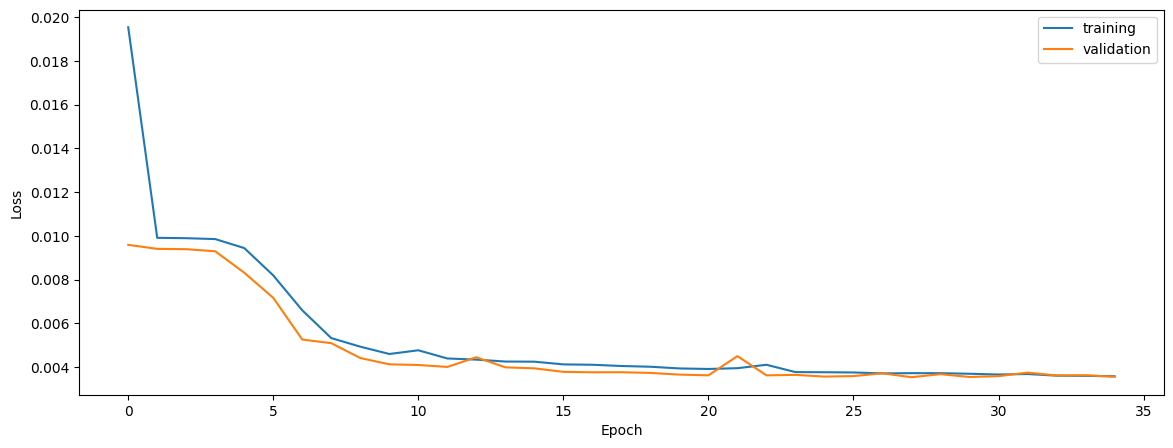

In [6]:
from util import pickleLoad
from visual import plotHistory

history = pickleLoad(path+'/{}.pkl'.format(HASHID))
plotHistory(history)

In [7]:
from util import getPearson, predictInBatches

train_pred = predictInBatches(model,train[0],architecture['batch_size'])
val_pred = predictInBatches(model,val[0],architecture['batch_size'])
test_pred = predictInBatches(model,test[0],architecture['batch_size'])

print('train')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

train
0.7959207724923419
0.7900722494244895
0.7885257948747362


In [8]:
print('native')
print(getPearson(train[1],train_pred))
print(getPearson(val[1],val_pred))
print(getPearson(test[1],test_pred))

native
0.7959207724923419
0.7900722494244895
0.7885257948747362


In [9]:
print('normalized')
print(getPearson(train[1][train[2]],train_pred[train[2]]))
print(getPearson(val[1][val[2]],val_pred[val[2]]))
print(getPearson(test[1][test[2]],test_pred[test[2]]))

normalized
0.7988255725326608
0.7892077274905887
0.7929523054109383


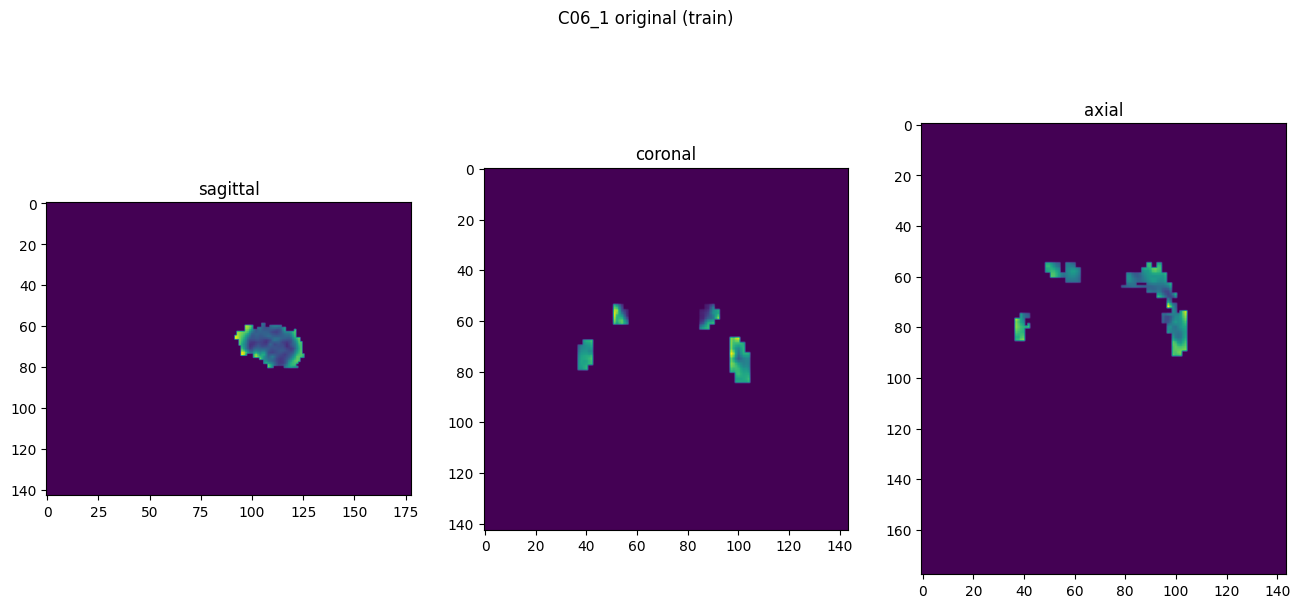

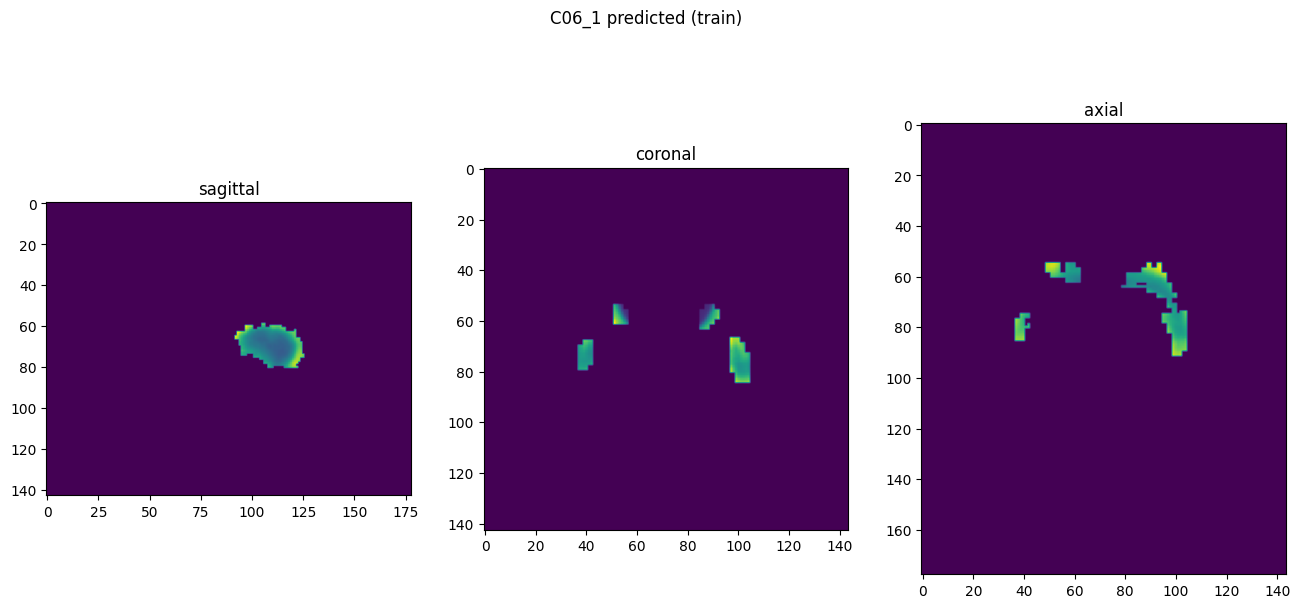

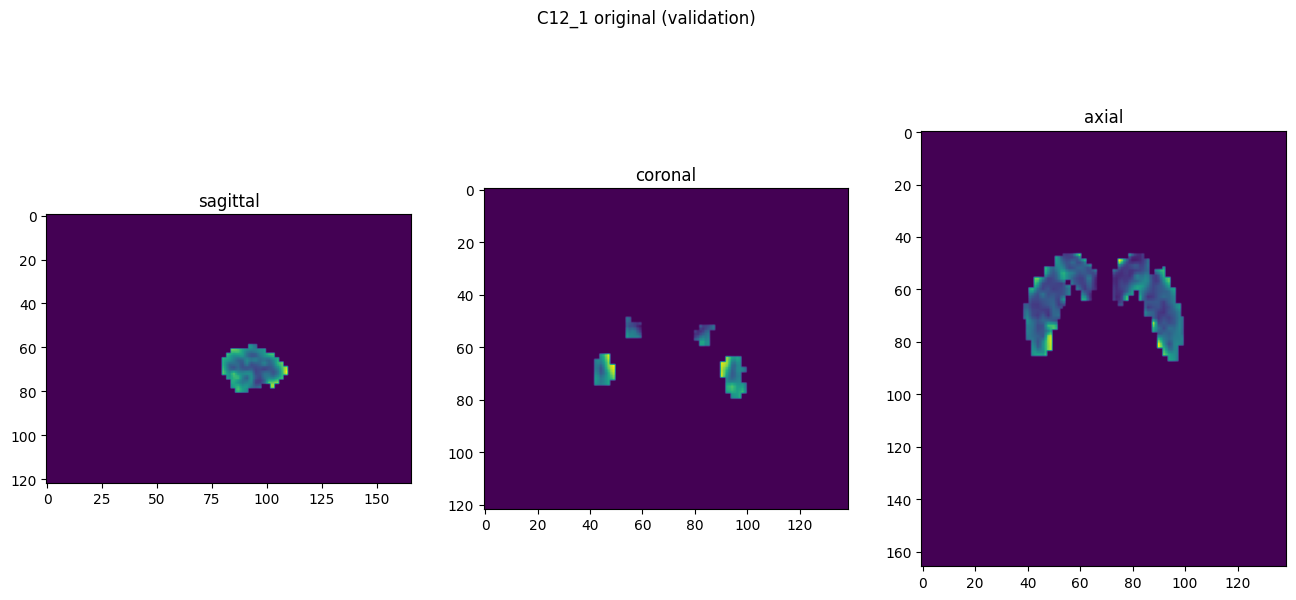

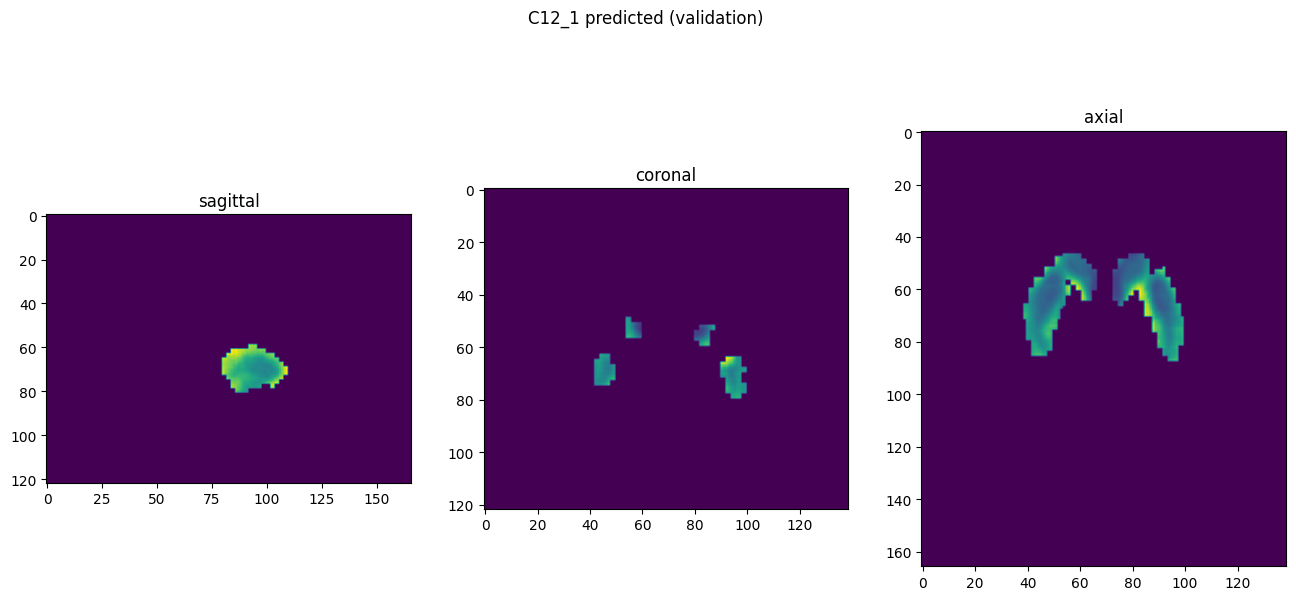

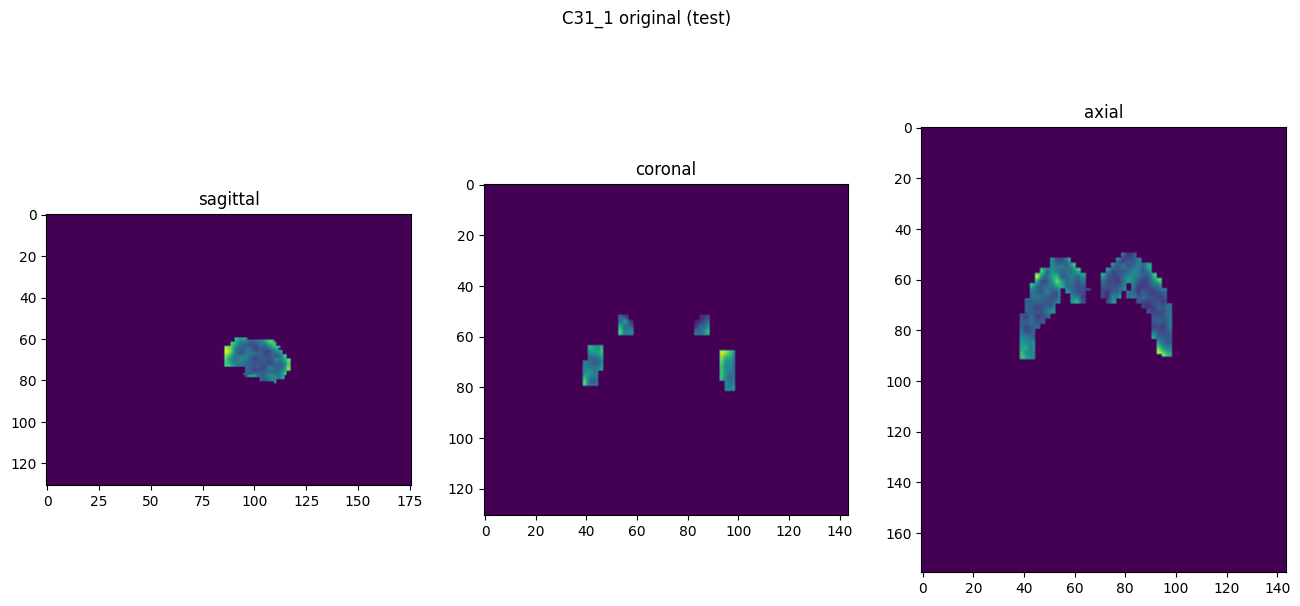

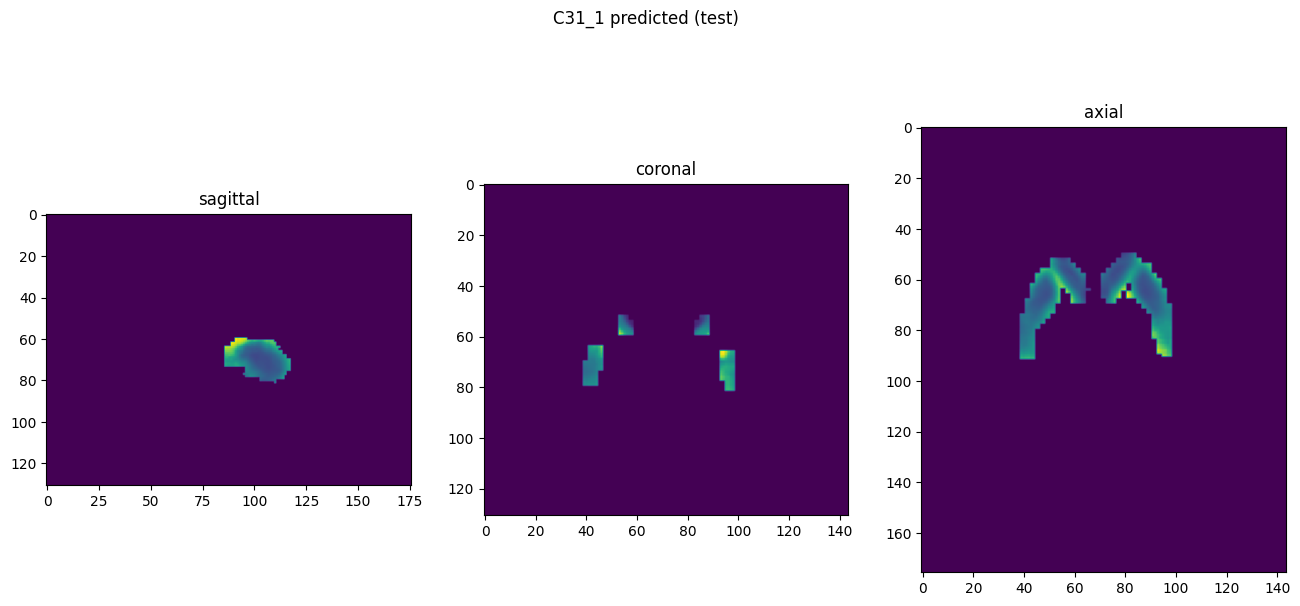

In [10]:
showResults(model, gen, threshold=None, background=False)